
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

In [4]:
import numpy as np
import mne
from tinnsleep.reports import combine_brux_MEMA, generate_bruxism_report, generate_MEMA_report
from tinnsleep.data import CreateRaw, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
from tinnsleep.utils import merge_labels_list
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tinnsleep.config import Config
import scipy.stats
print("Config loaded")


Config loaded


## Loading parameters and results

In [3]:


# change to --overwrite True if you want to force to recompute the results
#%run ../compute_results.py --bruxism True --mema True --overwrite False 

#mema_files= pd.read_csv("data/mema_files.csv",engine='python', sep=", ")["files_with_mema"].values

results_MEMA = pd.read_pickle("data/reports_and_datas_MEMA.pk").to_dict()
results_brux = pd.read_pickle("data/reports_and_datas_bruxism.pk").to_dict()
min_burst_joining_brux = 3 
min_burst_joining_MEMA = 0
EDF_list = Config.bruxisme_files
print(EDF_list)
print(results_brux.keys())
print(results_MEMA.keys())

[]
dict_keys(['1AC26_cohort2.edf', '1BA07_nuit_hab.edf', '1BA07_nuit_son.edf', '1CB23_cohort2.edf', '1CC05_nuit_hab.edf', '1CC05_nuit_son.edf', '1DA15_nuit_hab.edf', '1DA15_nuit_son.edf', '1DL12_nuit_hab.edf', '1DL12_nuit_son.edf', '1DM32_cohort2.edf', '1GB18_nuit_hab.edf', '1GB18_nuit_son.edf', '1GF14_cohort2.edf', '1GF14_nuit_son.edf', '1HB20_nuit_1.edf', '1HB20_nuit_1_resmed.edf', '1HB20_nuit_2.edf', '1HB20_nuit_2_resmed.edf', '1HB20_nuit_3.edf', '1HS25_cohort2.edf', '1MA16_nuit_hab.edf', '1MA16_nuit_son.edf', '1MF19_nuit_hab.edf', '1MF19_nuit_son.edf', '1MN09_nuit_hab.edf', '1MN09_nuit_son.edf', '1NS30_cohort2.edf', '1PA31_cohort2.edf', '1PI07_nuit_hab.edf', '1PI07_nuit_son.edf', '1PT06_nuit_hab.edf', '1PT06_nuit_son.edf', '1RA17_nuit_son.edf', '1RF29_cohort2.edf', '1SA14_nuit_hab.edf', '1SA14_nuit_son.edf', '1SL21_nuit_1.edf', '1SL21_nuit_2.edf', '1SL21_nuit_2_resmed.edf', '1SL21_nuit_3.edf', '1SL21_nuit_3_resmed.edf', '1SL21_nuit_6.edf', '1SL21_nuit_7.edf', '1SL21_nuit_8.edf', '1

## Bruxism + MEMA processing for pure MEMA visualisation

Files processed : 
1AC26_cohort2.edf 0.992
139032
3347
{'Clean data duration': 23530.736, 'Total burst duration': 830.056, 'Total number of burst': 1311, 'Number of bursts per hour': 200.57171182405853, 'bruxism episode NREM count': 113, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 113, 'Number of bursts per episode': 11.601769911504425, 'Number of episodes per hour': 17.28802702983876, 'Number of tonic episodes per hour': 2.7538450136026342, 'Number of phasic episodes per hour': 2.352395607175228, 'Number of mixed episodes per hour': 1.252081532851331, 'Mean duration of tonic episode': 5.7728888888891055, 'Mean duration of phasic episode': 5.484000000000158, 'Mean duration of mixed episode': 15.195636363636588, 'End count': 28, 'End ratio': 0.00020139248518326715, 'NREM count': 97135, 'NREM ratio': 0.6986521088670234, 'Wake count': 41780, 'Wake ratio': 0.3005063582484608, 'start count': 89, 'start ratio': 0.0006401403993325277, 'Power Ratio': array([14.28161079, 13.9

1CC05_nuit_hab.edf (does not have both bruxism and mema)... skipping
1CC05_nuit_son.edf (does not have both bruxism and mema)... skipping
1DA15_nuit_hab.edf 1.0
117720
6000
{'Clean data duration': 19939.75, 'Total burst duration': 1500.0, 'Total number of burst': 1303, 'Number of bursts per hour': 235.24868666858913, 'bruxism episode NREM count': 140, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 140, 'Number of bursts per episode': 9.307142857142857, 'Number of episodes per hour': 25.27614438495969, 'Number of tonic episodes per hour': 3.0692461038879624, 'Number of phasic episodes per hour': 3.2497899923519604, 'Number of mixed episodes per hour': 2.3019345779159717, 'Mean duration of tonic episode': 5.661764705882353, 'Mean duration of phasic episode': 5.802083333333333, 'Mean duration of mixed episode': 28.205882352941178, 'NREM count': 80520, 'NREM ratio': 0.6839959225280327, 'Wake count': 37092, 'Wake ratio': 0.3150866462793068, 'start count': 108, 'start ratio':

heu
219392
1452
5772
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
39
Nb épisodes bruxisme purs : 
159
nb episodes MEMA combinés : 
43
Nb épisodes MEMA purs : 
38
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
2.5804451951669365
Nb épisodes bruxisme purs : 
10.520276564911356
nb episodes MEMA combinés : 
2.845106240825084
Nb épisodes MEMA purs : 
2.5142799337523996
1GF14_nuit_hab.edf (does not have both bruxism and mema)... skipping
1GF14_nuit_son.edf (does not have both bruxism and mema)... skipping
1HB20_nuit_1.edf 1.0
98080
3894
{'Clean data duration': 20337.75, 'Total burst duration': 973.5, 'Total number of burst': 823, 'Number of bursts per hour': 145.67983183980527, 'bruxism episode NREM count': 107, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 107, 'Number of bursts per episode': 7.691588785046729, 'Number of episodes per hour': 18.940148246487443, 'Number of tonic episodes per hour': 7.080429251023343, 'Number of phasic

Interpolating non proportional list, expecting to have non-uniform shift across recording


1.0
98080
3894
{'Clean data duration': 20337.75, 'Total burst duration': 973.5, 'Total number of burst': 823, 'Number of bursts per hour': 145.67983183980527, 'bruxism episode NREM count': 107, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 107, 'Number of bursts per episode': 7.691588785046729, 'Number of episodes per hour': 18.940148246487443, 'Number of tonic episodes per hour': 7.080429251023343, 'Number of phasic episodes per hour': 1.5930965814802522, 'Number of mixed episodes per hour': 1.3718331673857727, 'Mean duration of tonic episode': 4.81875, 'Mean duration of phasic episode': 5.3125, 'Mean duration of mixed episode': 26.274193548387096, 'End count': 72, 'End ratio': 0.000734094616639478, 'NREM count': 81888, 'NREM ratio': 0.834910277324633, 'Wake count': 16080, 'Wake ratio': 0.1639477977161501, 'start count': 40, 'start ratio': 0.0004078303425774878, 'Power Ratio': array([14.99369241])}
167640
0.25


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
98080
8
4820
0.25
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
1
Nb épisodes bruxisme purs : 
107
nb episodes MEMA combinés : 
1
Nb épisodes MEMA purs : 
87
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.1468189233278956
Nb épisodes bruxisme purs : 
15.70962479608483
nb episodes MEMA combinés : 
0.1468189233278956
Nb épisodes MEMA purs : 
12.773246329526918
1HB20_nuit_2.edf 1.0
100320
6362
{'Clean data duration': 23956.75, 'Total burst duration': 1590.5, 'Total number of burst': 1108, 'Number of bursts per hour': 166.50004695962517, 'Total number of episodes': 118, 'Number of bursts per episode': 9.389830508474576, 'Number of episodes per hour': 17.73195445959907, 'Number of tonic episodes per hour': 5.860561219697997, 'Number of phasic episodes per hour': 1.8032496060609222, 'Number of mixed episodes per hour': 1.1645987039143457, 'Mean duration of tonic episode': 8.653846153846153, 'Mean duration of phasic episode': 5.8125, 'Mean duration of m

Interpolating non proportional list, expecting to have non-uniform shift across recording


1.0
100320
6362
{'Clean data duration': 23956.75, 'Total burst duration': 1590.5, 'Total number of burst': 1108, 'Number of bursts per hour': 166.50004695962517, 'Total number of episodes': 118, 'Number of bursts per episode': 9.389830508474576, 'Number of episodes per hour': 17.73195445959907, 'Number of tonic episodes per hour': 5.860561219697997, 'Number of phasic episodes per hour': 1.8032496060609222, 'Number of mixed episodes per hour': 1.1645987039143457, 'Mean duration of tonic episode': 8.653846153846153, 'Mean duration of phasic episode': 5.8125, 'Mean duration of mixed episode': 41.733870967741936, 'Power Ratio': array([19.43540849, 17.59843678])}
115280
0.25


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
100320
4655
2986
0.25
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
17
Nb épisodes bruxisme purs : 
101
nb episodes MEMA combinés : 
40
Nb épisodes MEMA purs : 
190
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
2.4401913875598087
Nb épisodes bruxisme purs : 
14.497607655502392
nb episodes MEMA combinés : 
5.741626794258373
Nb épisodes MEMA purs : 
27.272727272727273
1HB20_nuit_2_resmed.edf (does not have both bruxism and mema)... skipping
1HB20_nuit_3.edf (does not have both bruxism and mema)... skipping
1HS25_cohort2.edf 0.992
173264
6710
{'Clean data duration': 22669.184, 'Total burst duration': 1664.08, 'Total number of burst': 2093, 'Number of bursts per hour': 332.38073324562544, 'bruxism episode NREM count': 157, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 157, 'Number of bursts per episode': 13.331210191082803, 'Number of episodes per hour': 24.932525140737308, 'Number of tonic episodes per hour': 2.0644766040100957, 'Num

heu
146972
2045
5164
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
51
Nb épisodes bruxisme purs : 
99
nb episodes MEMA combinés : 
53
Nb épisodes MEMA purs : 
52
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
5.037167492074419
Nb épisodes bruxisme purs : 
9.778031014026812
nb episodes MEMA combinés : 
5.234703472155768
Nb épisodes MEMA purs : 
5.1359354821150935
1PA31_cohort2.edf 0.992
173548
7617
{'Clean data duration': 14537.264, 'Total burst duration': 1889.016, 'Total number of burst': 1885, 'Number of bursts per hour': 466.8003552800582, 'bruxism episode NREM count': 73, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 73, 'Number of bursts per episode': 25.82191780821918, 'Number of episodes per hour': 18.077679541349735, 'Number of tonic episodes per hour': 1.9811155661753135, 'Number of phasic episodes per hour': 2.7022416322631275, 'Number of mixed episodes per hour': 1.289706233580129, 'Mean duration of tonic episode': 15.

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
102580
1000
{'Clean data duration': 23257.44, 'Total burst duration': 248.0, 'Total number of burst': 302, 'Number of bursts per hour': 46.74633149650177, 'bruxism episode NREM count': 42, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 42, 'Number of bursts per episode': 7.190476190476191, 'Number of episodes per hour': 6.501145439910842, 'Number of tonic episodes per hour': 3.0957835428146865, 'Number of phasic episodes per hour': 0.5374280230326296, 'Number of mixed episodes per hour': 0.30710172744721687, 'Mean duration of tonic episode': 4.253199999999896, 'Mean duration of phasic episode': 6.075999999999632, 'Mean duration of mixed episode': 6.726999999999748, 'NREM count': 100281, 'NREM ratio': 0.9775882238253071, 'Wake count': 2274, 'Wake ratio': 0.022168063950087736, 'start count': 25, 'start ratio': 0.0002437122246051862, 'Power Ratio': array([94.2244824 , 96.19805384])}
111732
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
102580
83
924
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
3
Nb épisodes bruxisme purs : 
42
nb episodes MEMA combinés : 
3
Nb épisodes MEMA purs : 
111
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
0.42453097189290495
Nb épisodes bruxisme purs : 
5.94343360650067
nb episodes MEMA combinés : 
0.42453097189290495
Nb épisodes MEMA purs : 
15.707645960037484
1SL21_nuit_2_resmed.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_3.edf 0.992
145440
7115
{'Clean data duration': 32450.8, 'Total burst duration': 1764.52, 'Total number of burst': 864, 'Number of bursts per hour': 95.84971711020992, 'Total number of episodes': 208, 'Number of bursts per episode': 4.153846153846154, 'Number of episodes per hour': 23.074931896902388, 'Number of tonic episodes per hour': 13.201523537170116, 'Number of phasic episodes per hour': 1.0454719144058082, 'Number of mixed episodes per hour': 1.403133358807795, 'Mean duration of tonic episode': 7.7

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
145440
7115
{'Clean data duration': 32450.8, 'Total burst duration': 1764.52, 'Total number of burst': 864, 'Number of bursts per hour': 95.84971711020992, 'Total number of episodes': 208, 'Number of bursts per episode': 4.153846153846154, 'Number of episodes per hour': 23.074931896902388, 'Number of tonic episodes per hour': 13.201523537170116, 'Number of phasic episodes per hour': 1.0454719144058082, 'Number of mixed episodes per hour': 1.403133358807795, 'Mean duration of tonic episode': 7.760941176470496, 'Mean duration of phasic episode': 4.705473684210519, 'Mean duration of mixed episode': 13.455215686274391, 'Power Ratio': array([163.85149789,  91.5153819 ])}
139152
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
145440
644
6739
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
16
Nb épisodes bruxisme purs : 
194
nb episodes MEMA combinés : 
17
Nb épisodes MEMA purs : 
210
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
1.5969338869370806
Nb épisodes bruxisme purs : 
19.3628233791121
nb episodes MEMA combinés : 
1.6967422548706481
Nb épisodes MEMA purs : 
20.959757266049184
1SL21_nuit_3_resmed.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_4.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_5.edf (does not have both bruxism and mema)... skipping
1SL21_nuit_6.edf 1.0
141520
10341
{'Clean data duration': 29687.25, 'Total burst duration': 2585.25, 'Total number of burst': 280, 'Number of bursts per hour': 33.95397013869591, 'Total number of episodes': 54, 'Number of bursts per episode': 5.185185185185185, 'Number of episodes per hour': 6.548265669605639, 'Number of tonic episodes per hour': 4.608038804537301, 'Number of phasic

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
187376
5323
{'Clean data duration': 24838.936, 'Total burst duration': 1320.104, 'Total number of burst': 1615, 'Number of bursts per hour': 234.0679971154964, 'bruxism episode NREM count': 216, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 216, 'Number of bursts per episode': 7.476851851851852, 'Number of episodes per hour': 31.305688778295494, 'Number of tonic episodes per hour': 5.652416029414464, 'Number of phasic episodes per hour': 4.0256796828978505, 'Number of mixed episodes per hour': 2.336331958824645, 'Mean duration of tonic episode': 3.459282051282431, 'Mean duration of phasic episode': 5.170357142857321, 'Mean duration of mixed episode': 9.90855384615419, 'End count': 33, 'End ratio': 0.00017611647169327982, 'NREM count': 100403, 'NREM ratio': 0.5358370335581931, 'Wake count': 86855, 'Wake ratio': 0.46353321663393393, 'start count': 85, 'start ratio': 0.00045363333617966017, 'Power Ratio': array([26.84406224, 21.04751817])}
186532
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
187376
1566
4332
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
47
Nb épisodes bruxisme purs : 
184
nb episodes MEMA combinés : 
47
Nb épisodes MEMA purs : 
490
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
3.641117669905052
Nb épisodes bruxisme purs : 
14.254588324734671
nb episodes MEMA combinés : 
3.641117669905052
Nb épisodes MEMA purs : 
37.960588473478204
1UC22_nuit_1_resmed.edf (does not have both bruxism and mema)... skipping
1UC22_nuit_2.edf 0.992
121732
9174
{'Clean data duration': 29304.92, 'Total burst duration': 2275.152, 'Total number of burst': 2607, 'Number of bursts per hour': 320.2602156907441, 'Total number of episodes': 335, 'Number of bursts per episode': 7.782089552238806, 'Number of episodes per hour': 41.15349913939366, 'Number of tonic episodes per hour': 7.493622231352279, 'Number of phasic episodes per hour': 5.087800956289933, 'Number of mixed episodes per hour': 3.259848516904329, 'Mean duration of tonic episode':

Interpolating non proportional list, expecting to have non-uniform shift across recording


0.992
121732
9174
{'Clean data duration': 29304.92, 'Total burst duration': 2275.152, 'Total number of burst': 2607, 'Number of bursts per hour': 320.2602156907441, 'Total number of episodes': 335, 'Number of bursts per episode': 7.782089552238806, 'Number of episodes per hour': 41.15349913939366, 'Number of tonic episodes per hour': 7.493622231352279, 'Number of phasic episodes per hour': 5.087800956289933, 'Number of mixed episodes per hour': 3.259848516904329, 'Mean duration of tonic episode': 3.9273442622951804, 'Mean duration of phasic episode': 7.396934131736526, 'Mean duration of mixed episode': 14.917084112149654, 'Power Ratio': array([25.10533898, 28.583478  ])}
134472
0.248


Interpolating non proportional list, expecting to have non-uniform shift across recording


heu
121732
3608
9217
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
66
Nb épisodes bruxisme purs : 
273
nb episodes MEMA combinés : 
73
Nb épisodes MEMA purs : 
389
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
7.870276641548912
Nb épisodes bruxisme purs : 
32.55432610822505
nb episodes MEMA combinés : 
8.70500295201622
Nb épisodes MEMA purs : 
46.38693353882616
1UC22_nuit_2_resmed.edf (does not have both bruxism and mema)... skipping
1UC22_nuit_3.edf (does not have both bruxism and mema)... skipping
1ZN04_cohort2.edf 0.992
130684
4512
{'Clean data duration': 25495.392, 'Total burst duration': 1118.9759999999999, 'Total number of burst': 1767, 'Number of bursts per hour': 249.50391035368273, 'bruxism episode NREM count': 123, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 123, 'Number of bursts per episode': 14.365853658536585, 'Number of episodes per hour': 17.367844353991497, 'Number of tonic episodes per hour': 1.12961589294253

heu
93668
8206
2199
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
71
Nb épisodes bruxisme purs : 
48
nb episodes MEMA combinés : 
86
Nb épisodes MEMA purs : 
105
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
11.003172495306002
Nb épisodes bruxisme purs : 
7.438764503868846
nb episodes MEMA combinés : 
13.327786402765016
Nb épisodes MEMA purs : 
16.2722973522131
2LS05_nuit_1.edf 0.992
102016
3810
{'Clean data duration': 23252.232, 'Total burst duration': 944.88, 'Total number of burst': 827, 'Number of bursts per hour': 128.0393211283975, 'bruxism episode NREM count': 69, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 69, 'Number of bursts per episode': 11.985507246376812, 'Number of episodes per hour': 10.682845414582136, 'Number of tonic episodes per hour': 3.096476931762938, 'Number of phasic episodes per hour': 1.5358525581544171, 'Number of mixed episodes per hour': 0.3455668255847439, 'Mean duration of tonic episode': 16.715

heu
155480
5824
4035
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
137
Nb épisodes bruxisme purs : 
118
nb episodes MEMA combinés : 
149
Nb épisodes MEMA purs : 
58
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
12.790774874063253
Nb épisodes bruxisme purs : 
11.016871789339152
nb episodes MEMA combinés : 
13.911134717046895
Nb épisodes MEMA purs : 
5.41507257442094
0.992
155480
8809
{'Clean data duration': 20928.472, 'Total burst duration': 2184.632, 'Total number of burst': 987, 'Number of bursts per hour': 169.7782809944271, 'bruxism episode NREM count': 255, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 255, 'Number of bursts per episode': 3.8705882352941177, 'Number of episodes per hour': 43.86368961862098, 'Number of tonic episodes per hour': 19.7816639456526, 'Number of phasic episodes per hour': 1.9196814750737654, 'Number of mixed episodes per hour': 4.052660891822393, 'Mean duration of tonic episode': 8.531200000000057,

heu
169112
4357
4346
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
29
Nb épisodes bruxisme purs : 
81
nb episodes MEMA combinés : 
33
Nb épisodes MEMA purs : 
19
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
2.489283681438833
Nb épisodes bruxisme purs : 
6.952826834363636
nb episodes MEMA combinés : 
2.8326331547407406
Nb épisodes MEMA purs : 
1.630909998184063
3KB06_cohort2.edf 0.992
140480
2899
{'Clean data duration': 14603.976, 'Total burst duration': 718.952, 'Total number of burst': 636, 'Number of bursts per hour': 156.77922231589534, 'bruxism episode NREM count': 97, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 97, 'Number of bursts per episode': 6.556701030927835, 'Number of episodes per hour': 23.911296485285924, 'Number of tonic episodes per hour': 6.655721702089896, 'Number of phasic episodes per hour': 1.6506189821182942, 'Number of mixed episodes per hour': 2.6287635641143208, 'Mean duration of tonic episode': 4.89

heu
172580
1483
4283
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
37
Nb épisodes bruxisme purs : 
59
nb episodes MEMA combinés : 
39
Nb épisodes MEMA purs : 
38
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
3.112161166957634
Nb épisodes bruxisme purs : 
4.962635374337848
nb episodes MEMA combinés : 
3.28038609490129
Nb épisodes MEMA purs : 
3.1962736309294617
3TR07_cohort2.edf 0.992
185160
2817
{'Clean data duration': 23546.112, 'Total burst duration': 698.616, 'Total number of burst': 797, 'Number of bursts per hour': 121.85451254117876, 'bruxism episode NREM count': 88, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 88, 'Number of bursts per episode': 9.056818181818182, 'Number of episodes per hour': 13.45445056916403, 'Number of tonic episodes per hour': 3.057829674810007, 'Number of phasic episodes per hour': 1.7062689585439839, 'Number of mixed episodes per hour': 0.8720930232558138, 'Mean duration of tonic episode': 4.8856

C:\Users\Zeta\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Zeta\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


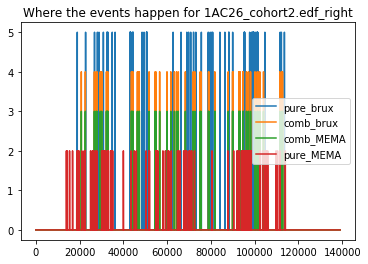

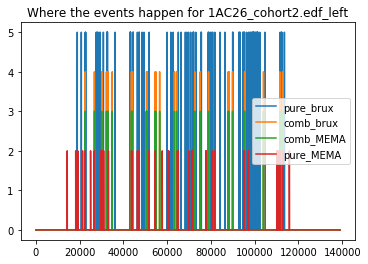

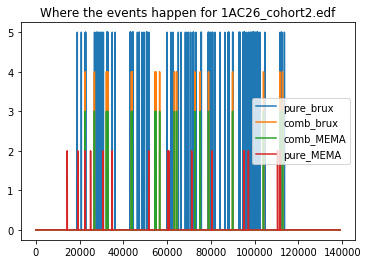

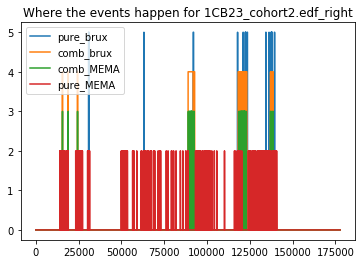

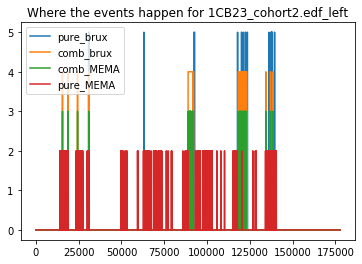

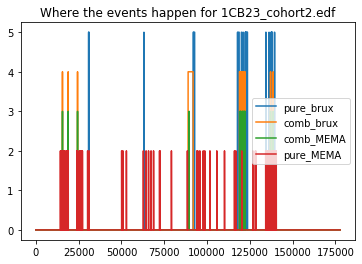

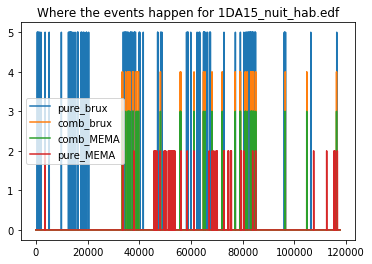

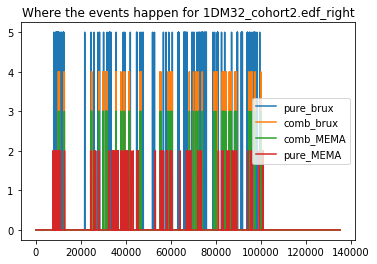

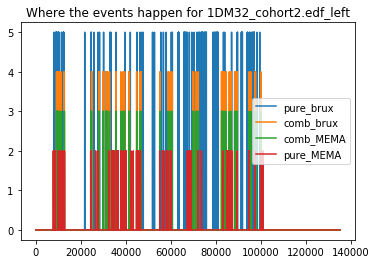

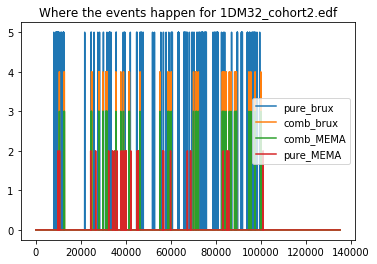

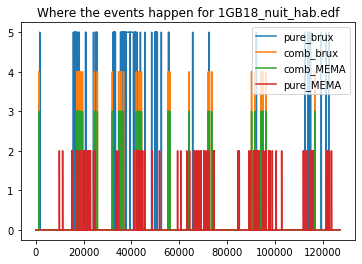

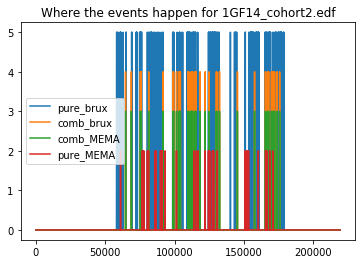

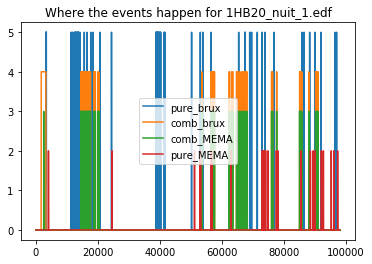

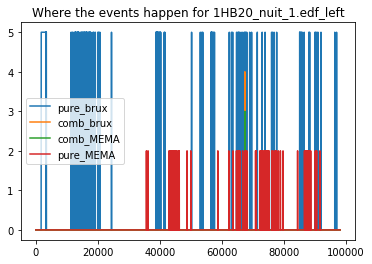

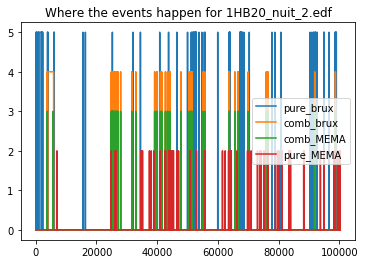

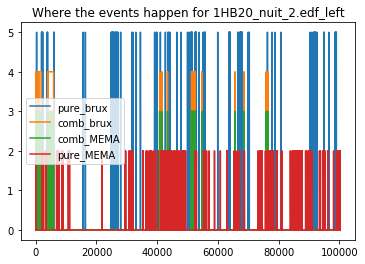

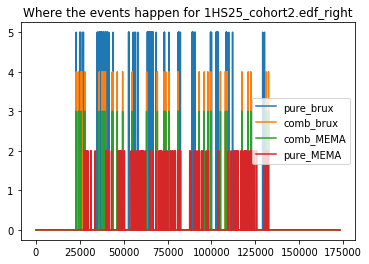

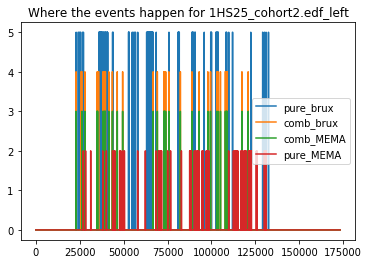

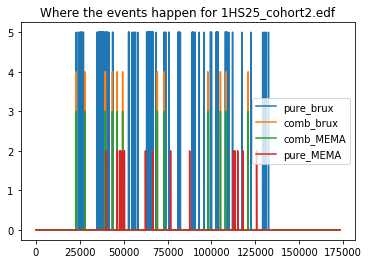

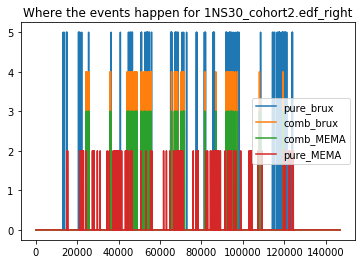

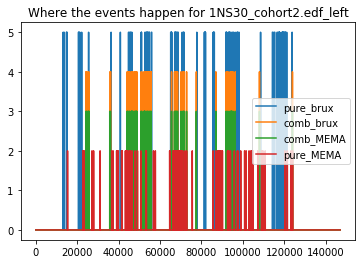

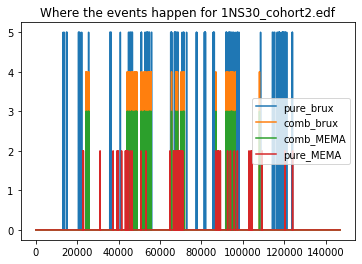

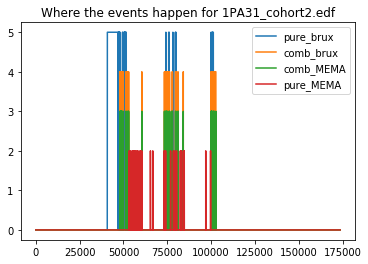

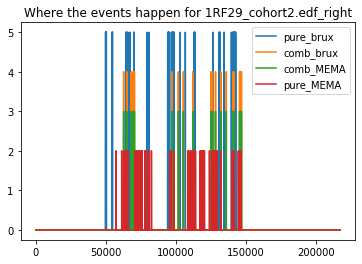

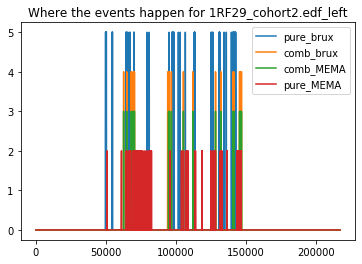

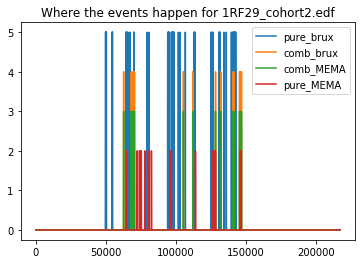

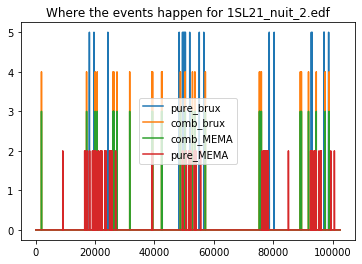

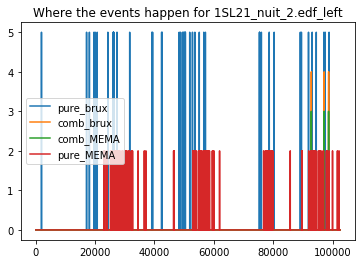

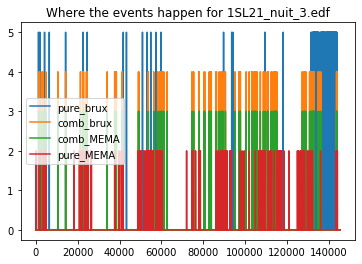

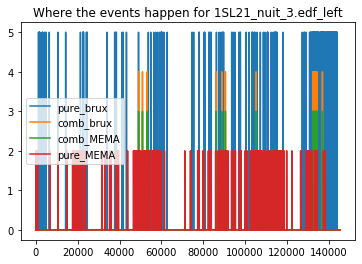

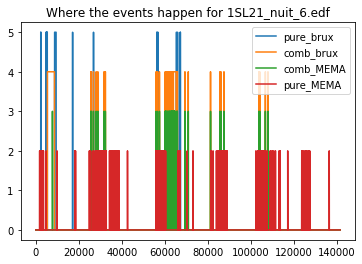

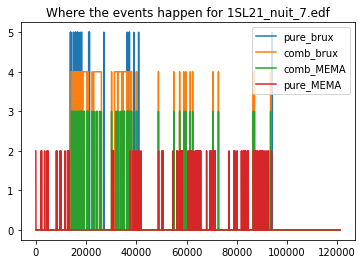

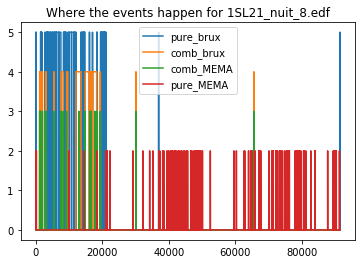

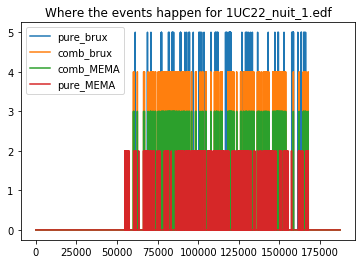

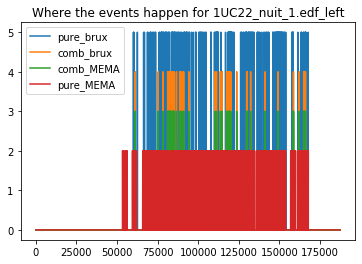

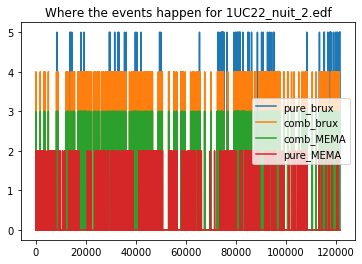

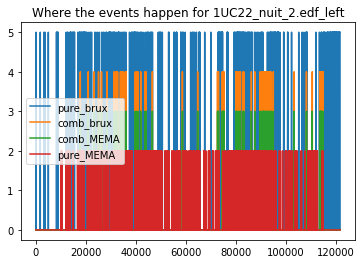

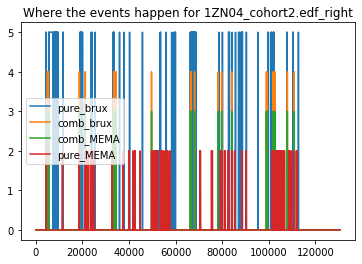

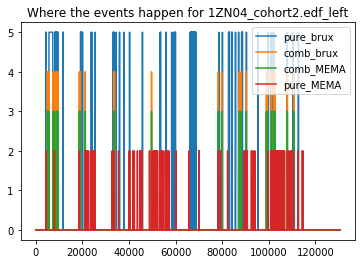

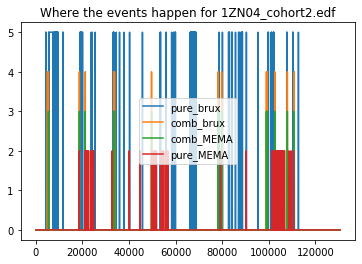

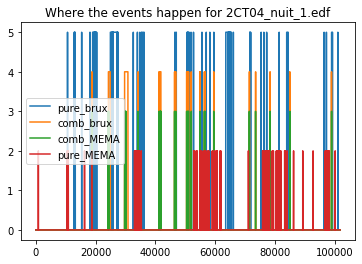

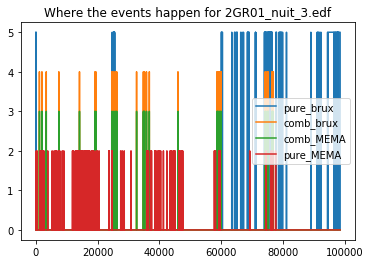

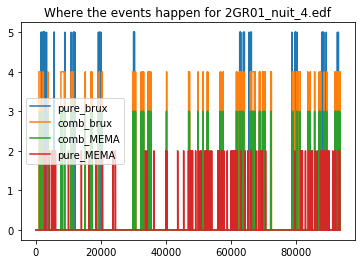

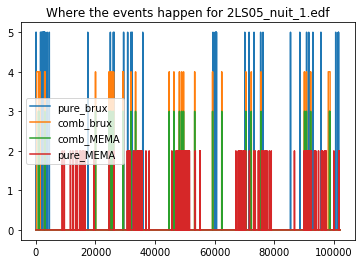

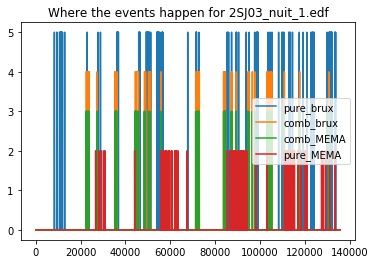

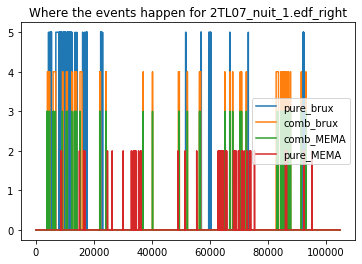

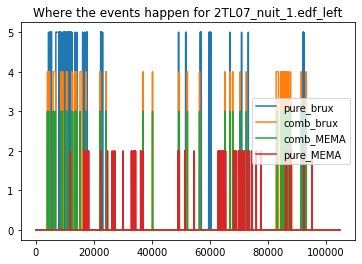

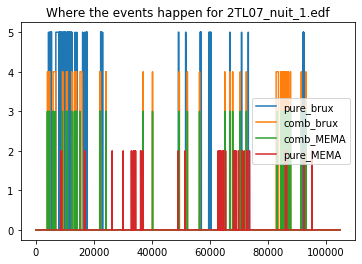

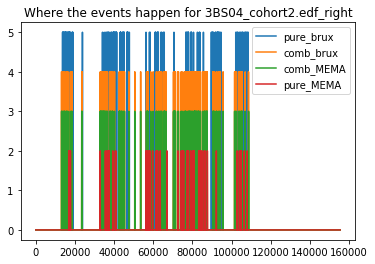

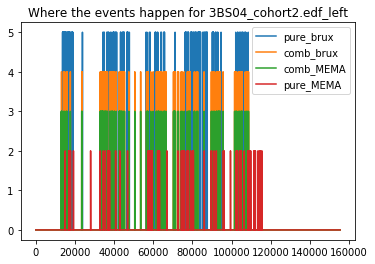

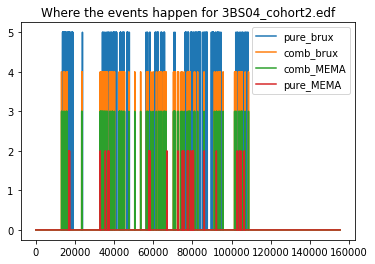

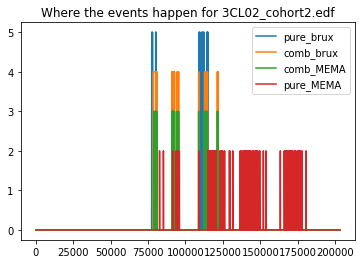

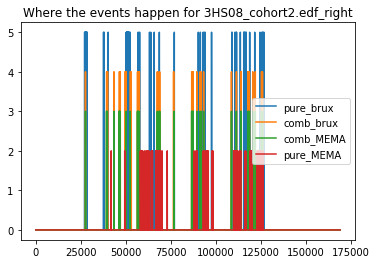

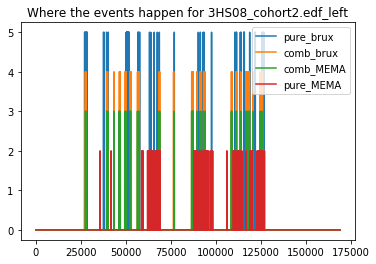

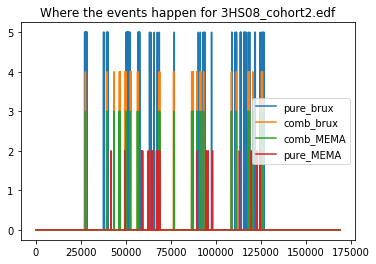

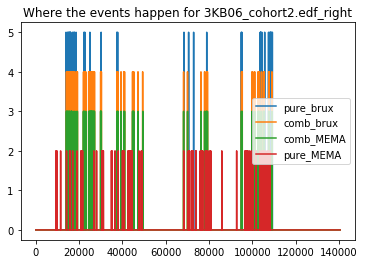

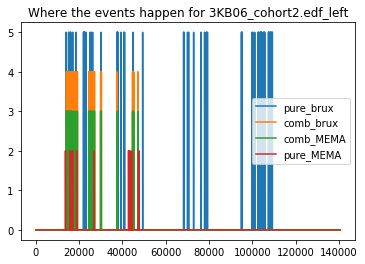

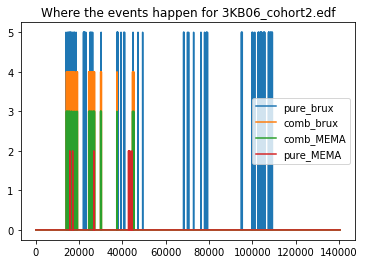

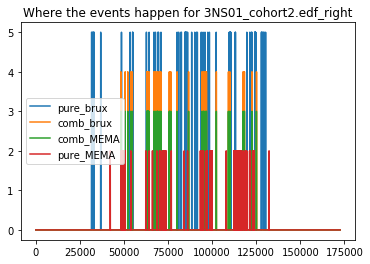

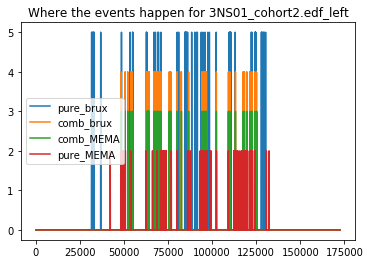

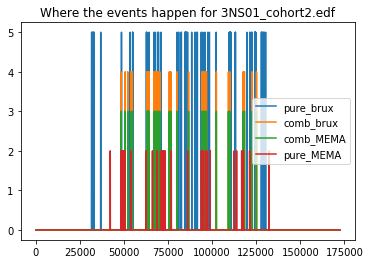

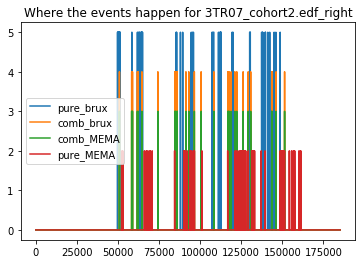

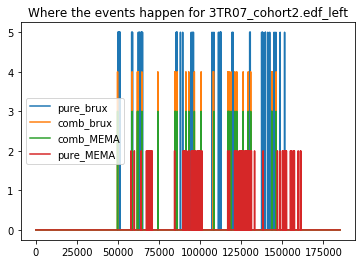

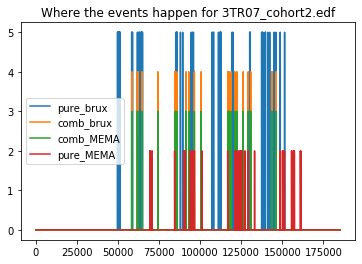

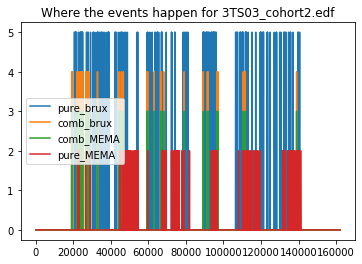

In [4]:
from time import time
# load file from config

ind_THR_brux=0
ind_THR_MEMA = 0

start = time()
results_brux_combine={}
results_brux_pure={}
results_MEMA_combine={}
results_MEMA_pure={}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in EDF_list:
        
        #Tester si le fichier has left
        
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        
        
        if (list(results_MEMA.keys()).__contains__(file+"_left")):
            if file ==  "1HB20_nuit_1.edf" or file ==  "1UC22_nuit_1.edf" or file ==  "1SL21_nuit_2.edf"  or file ==  "1HB20_nuit_2.edf" or file ==  "1UC22_nuit_2.edf" or file ==  "1SL21_nuit_3.edf":
                file_sides=[file, file+"_left"]
            else:
               
                    file_sides=[file+"_right", file+"_left", file] 
        else:
                file_sides=[file]
            
            
        print(file, end=" ")
        if not (file in results_brux.keys() and file in results_MEMA.keys()):
            #print(results_brux[file]["parameters"]["time_interval"])
            print(f"(does not have both bruxism and mema)... skipping")
        else:
            for file_side in file_sides:
                window_length_brux = results_brux[file]["parameters"]["time_interval"]
                delim_brux = results_brux[file]["parameters"]["delim"]
                window_length_MEMA = results_MEMA[file]["parameters"]["time_interval"]
                delim_MEMA = results_MEMA[file]["parameters"]["delim"]
                params_combine = dict(
                                    labels_brux = results_brux[file]["labels"][ind_THR_brux], 
                                    time_interval_brux = results_brux[file]["parameters"]["time_interval"], 
                                    delim_ep_brux = results_brux[file]["parameters"]["delim"], 
                                    labels_MEMA = results_MEMA[file_side]["labels"][ind_THR_MEMA], #droite ou gauche
                                    time_interval_MEMA = results_MEMA[file]["parameters"]["time_interval"],
                                    delim_ep_MEMA = results_brux[file]["parameters"]["delim"],
                                    min_burst_joining_brux=min_burst_joining_brux, 
                                    min_burst_joining_MEMA=min_burst_joining_MEMA
                                    )
                print(results_MEMA[file_side]["parameters"]["time_interval"])
                print(len(results_brux[file]["labels"][0]))
                print(np.sum(results_brux[file]["labels"][0]))
                print(results_brux[file]["reports"][0])
                print(len(results_MEMA[file_side]["labels"][0])*4)
                print(results_brux[file]["parameters"]["time_interval"])
                print(results_MEMA[file]["reports"][0])

                brux_comb_ep, brux_pure_ep, MEMA_comb_ep, MEMA_pure_ep = combine_brux_MEMA(**params_combine)
                valid_labels_MEMA= results_MEMA[file_side]["parameters"]["valid_labels"]
                valid_labels_brux= results_brux[file]["parameters"]["valid_labels"]
                #LIGNE IMPORTANTE A CONSERVER
                valid_labels_MEMA = merge_labels_list([valid_labels_MEMA], len(valid_labels_brux))


                results_brux_combine[file_side]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [brux_comb_ep]     ,              
                    "reports": [generate_bruxism_report(brux_comb_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                    }

                results_brux_pure[file_side]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [brux_pure_ep]     ,              
                    "reports": [generate_bruxism_report(brux_pure_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                    }


                results_MEMA_combine[file_side]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [MEMA_comb_ep]     ,              
                    "reports": [generate_MEMA_report(MEMA_comb_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}

                results_MEMA_pure[file_side]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                     "labels": [ MEMA_pure_ep  ]   ,              
                    "reports": [generate_MEMA_report(MEMA_pure_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}

                print("heu")
                print(len(MEMA_comb_ep))
                print(np.sum(brux_comb_ep))
                print(np.sum(brux_pure_ep))
                print(window_length_brux)
                print(delim_brux)
                print(min_burst_joining_brux)

                pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
                li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= 0)#important!!
                pure_brux_events = episodes_to_list(li_ep_brux_p, window_length_brux, len(brux_pure_ep))

                comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
                li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= 0) #Important!!
                comb_brux_events = episodes_to_list(li_ep_brux_c, window_length_brux, len(brux_comb_ep))

                comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux) # window_length_brux is valid ?

                pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux) # window_length_brux is valid ?

                print("rapport d'activité : ")
                print("nb episodes bruxisme combinés : ")
                print(len(li_ep_brux_c))
                print("Nb épisodes bruxisme purs : ")
                print(len(li_ep_brux_p))
                print("nb episodes MEMA combinés : ")
                print(len(comb_MEMA_bursts))
                print("Nb épisodes MEMA purs : ")
                print(len(pure_MEMA_bursts))


                print("rapport d'activité taux horaire : ")
                print("nb episodes bruxisme combinés : ")
                print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("Nb épisodes bruxisme purs : ")
                print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("nb episodes MEMA combinés : ")
                print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("Nb épisodes MEMA purs : ")
                print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))

                new_l_comb=[]
                for i in range(len(MEMA_comb_ep)):
                    if MEMA_comb_ep[i]:
                        new_l_comb.append(3)
                    else:
                        new_l_comb.append(0)

                new_l_pure=[]
                for i in range(len(MEMA_pure_ep)):
                    if MEMA_pure_ep[i]:
                        new_l_pure.append(2)
                    else:
                        new_l_pure.append(0)

                for i in range(len(comb_brux_events)):
                    if comb_brux_events[i]>0:
                        comb_brux_events[i]=4

                for i in range(len(pure_brux_events)):
                    if pure_brux_events[i]>0:
                        pure_brux_events[i]=5

                plt.figure()
                plt.plot(pure_brux_events, label="pure_brux")
                plt.plot(comb_brux_events, label="comb_brux")
                plt.plot(new_l_comb, label="comb_MEMA")
                plt.plot(new_l_pure, label="pure_MEMA")
                plt.legend()
                plt.title("Where the events happen for " + file_side)


pd.DataFrame.from_dict(results_brux_combine).to_pickle("data/reports_and_datas_bruxism_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_brux_pure).to_pickle("data/reports_and_datas_bruxism_pure.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_combine).to_pickle("data/reports_and_datas_MEMA_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_pure).to_pickle("data/reports_and_datas_MEMA_pure.pk", protocol=3)
print("results saved!!")

## Display of the last computed recording

In [3]:
raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
duration_brux = int(results_brux[file]["parameters"]["time_interval"] * raw.info['sfreq'])  
interval_brux=duration_brux
print(duration_brux)

#print(new_l_comb)

#print(len(raw))
#-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
#Preparing raw for visualisation
picks_chan = ['Mask Pressure', '1', '2', "Activity"]           # subset of EMG electrodes

print(raw.info["sfreq"])

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=['misc','emg','emg', "misc"])        # pick channels and load
print(len(raw))
scalings = dict(misc=1, emg=1e-5)

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])
#Annotating the raw
raw = CleanAnnotations(raw)
dict_annotations = {1: "b_pure", 2:"M_pure", 3:"M_comb", 4:"b_comb"}
#raw = AnnotateRaw_sliding(raw, results_brux[file]["labels"][ind_THR_brux][1:-1] , 
#                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_pure[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)

raw = AnnotateRaw_sliding(raw,  pure_brux_events[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, comb_brux_events[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_comb[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)


print("Raw annotated")
scalings = {'emg': 5e-5, 'misc': 0.2, 'bio':1e3}
raw.plot(scalings = scalings)
plt.title(filename)

NameError: name 'filename' is not defined

## Analysis 

In [10]:
from tinnsleep.data import read_etiology_file
etiology_file = "data/etiology.xlsx"
#Here replace with the metric to analyse
info_file = "data/data_info.csv"
results_file = "data/reports_and_datas_MEMA_pure.pk"
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & emg == 1 & included == 1 & session == "1" & Right_ears != "0" ')
#print(data_info["Controlateral"])
etiology = read_etiology_file(etiology_file)
data_info = data_info.merge(etiology,on="subject")
#print(data_info.keys())
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema {data_info.shape[0]}")
print(data_info[["filename", "subject", "mema", "emg", "condition", "neck_pain", "Ear_select"]])

# keep only results from query
#results= {filename:results[filename] for filename in data_info["Ear_select"].values}
#results= {filename:results[filename] for filename in data_info["filename"].values}
#results= {filename:results[filename] for filename in data_info["Controlateral"].values}
results= {filename:results[filename] for filename in data_info["Right_ears"].values}
print(results.keys())

Valid files for mema 22
              filename subject  mema  emg    condition  neck_pain  \
0   1DA15_nuit_hab.edf   1DA15     1    1  habituation       True   
1   1GB18_nuit_hab.edf   1GB18     1    1  habituation      False   
2     1HB20_nuit_1.edf   1HB20     1    1  habituation       True   
3     1SL21_nuit_2.edf   1SL21     1    1  habituation      False   
4     1UC22_nuit_1.edf   1UC22     1    1  habituation      False   
5     2SJ03_nuit_1.edf   2SJ03     1    1      control      False   
6     2LS05_nuit_1.edf   2LS05     1    1      control      False   
7     2CT04_nuit_1.edf   2CT04     1    1      control      False   
8    1ZN04_cohort2.edf   1ZN04     1    1       batch2      False   
9    1HS25_cohort2.edf   1HS25     1    1       batch2       True   
10   1PA31_cohort2.edf   1PA31     1    1       batch2       True   
11   3NS01_cohort2.edf   3NS01     1    1       batch2       True   
12   1RF29_cohort2.edf   1RF29     1    1       batch2       True   
13   1GF14

No handles with labels found to put in legend.


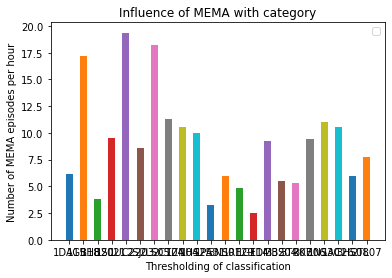

In [12]:
# visualization function
#plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
width = 0.5
for filename in results.keys():
    #print(results[filename]["reports"][0][value])
    plt.bar(filename[:5], results[filename]["reports"][0][value], width)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
#plt.tight_layout()
plt.legend()



In [13]:
# format reports
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
#putting away damaged recordings
data_info["category"] = data_info["mask_delta"].apply(map_category)
#data_info["filename"] = data_info["Ear_select"]
#data_info["filename"] = data_info["Controlateral"]
data_info["filename"] = data_info["Right_ears"]

reports = reports.merge(data_info, on="filename")

In [14]:
##Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus decrease : 9, ['1DA15', '1HB20', '1SL21', '1ZN04', '3NS01', '3BS04', '3TR07', '3KB06', '3HS08']
Tinnitus increase : 7, ['1GB18', '1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26']
Tinnitus control : 4, ['2SJ03', '2LS05', '2CT04', '2TL07']
Tinnitus stable : 2, ['1PA31', '1RF29']


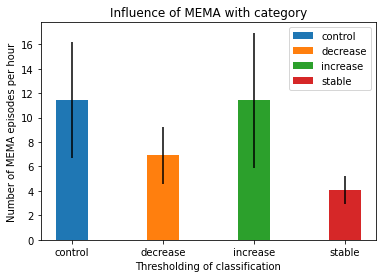

In [15]:
#Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
width = 0.35
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.bar(category, report_mean.loc[category][value], width, yerr = report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

In [16]:
l=[]
for i in range(4):
    print(list(reports.groupby(['category', 'THR_classif']))[i][0])
    print(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
    l.append(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
print(scipy.stats.ttest_ind(l[0], l[2]))
print(scipy.stats.ttest_ind(l[1], l[2]))
print(scipy.stats.ttest_ind(l[3], l[2]))

('control', 3)
[8.551223252486269, 18.21346177196746, 11.2636446936352, 7.748133991063819]
('decrease', 3)
[6.116207951070336, 3.8172920065252853, 9.481191705608211, 10.552418490898013, 5.971984941999784, 5.508435894669577, 5.331047603119186, 9.403244176647807, 6.00861578278339]
('increase', 3)
[17.202137692549513, 19.367647180346022, 9.969868840836583, 2.5142799337523996, 9.2390992952501, 11.062014884555584, 10.545263193063931]
('stable', 3)
[3.262089060421696, 4.879348635921274]
Ttest_indResult(statistic=0.008988814507760515, pvalue=0.9930241567408251)
Ttest_indResult(statistic=-2.224067410891948, pvalue=0.04310808026030708)
Ttest_indResult(statistic=-1.7817659975467302, pvalue=0.11798993018630934)


In [17]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys()) #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


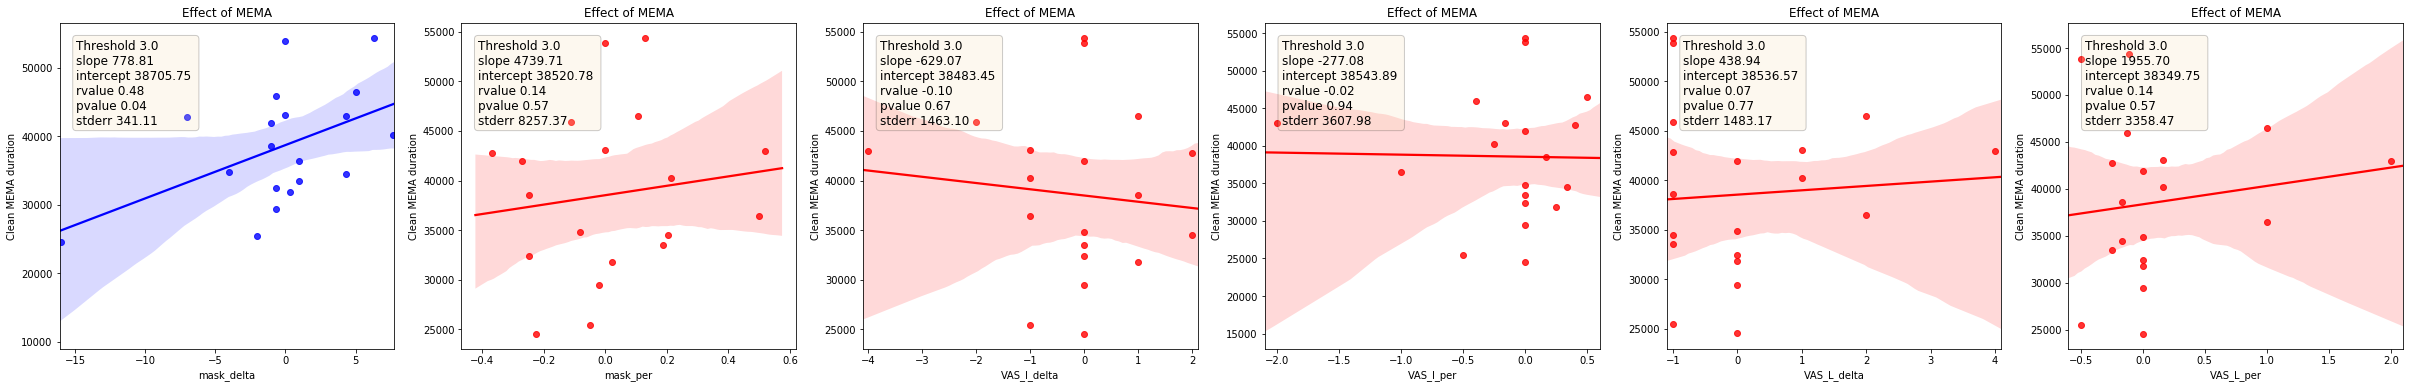

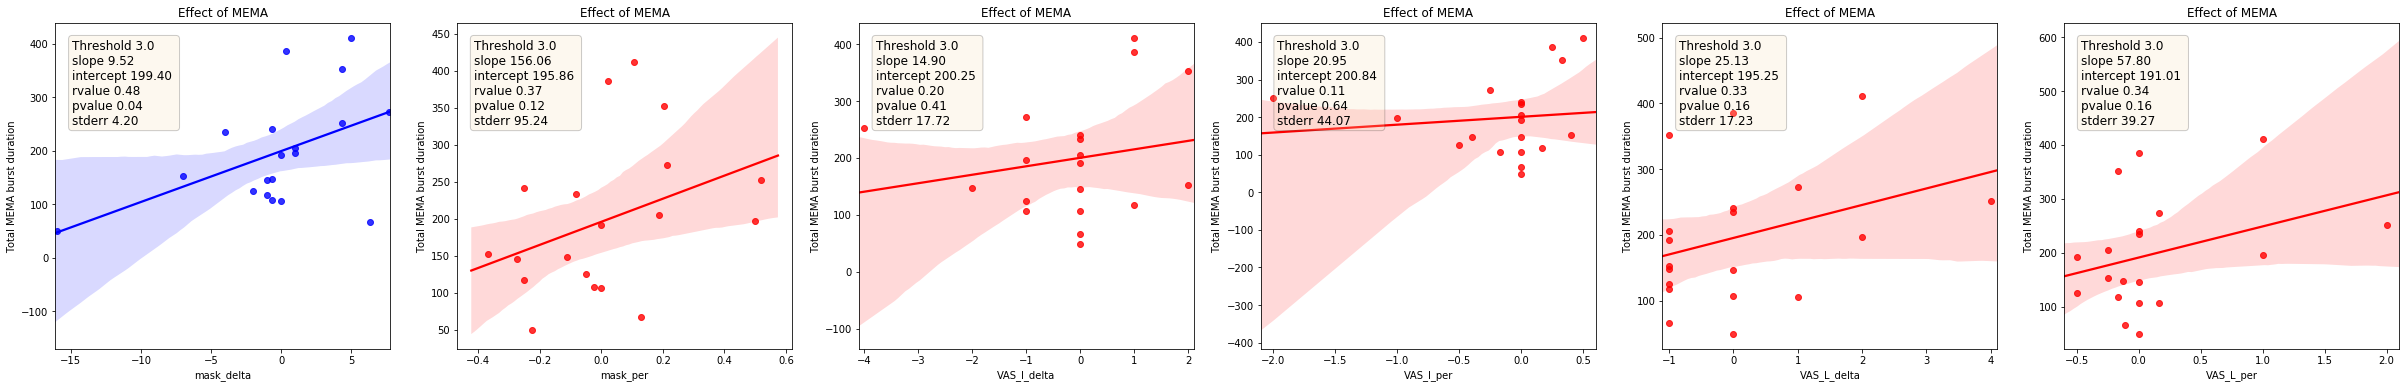

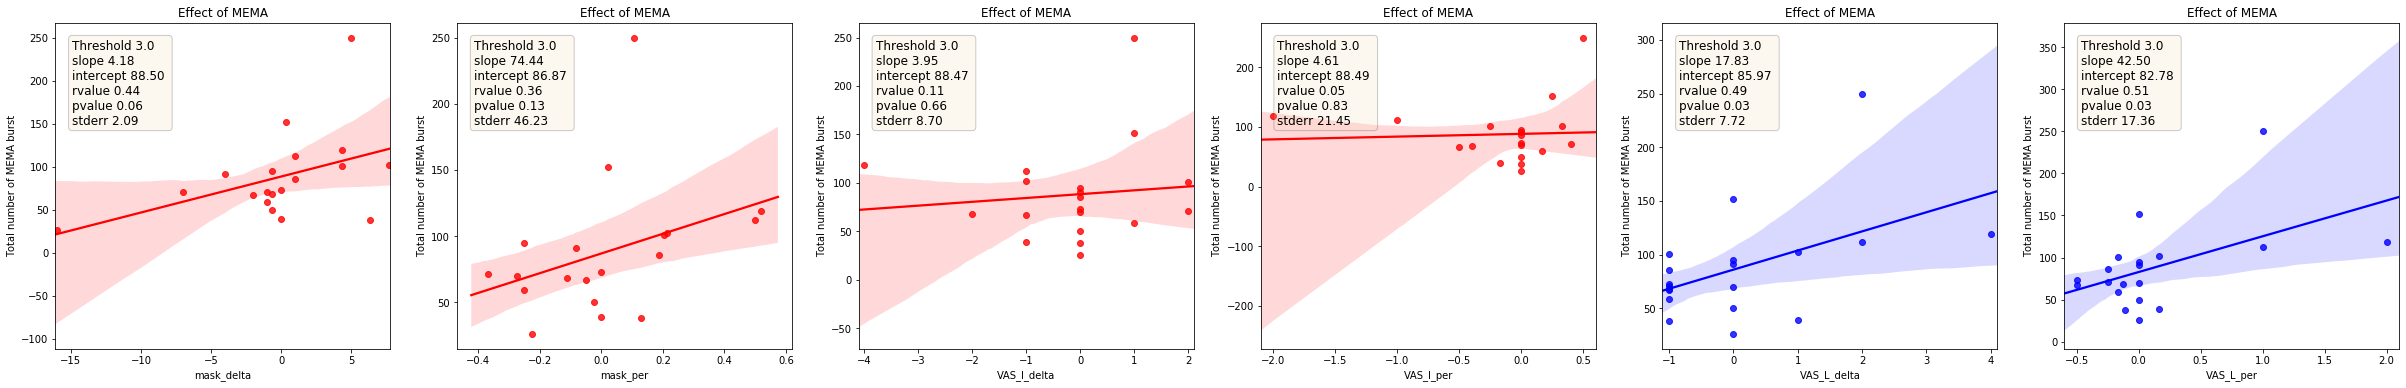

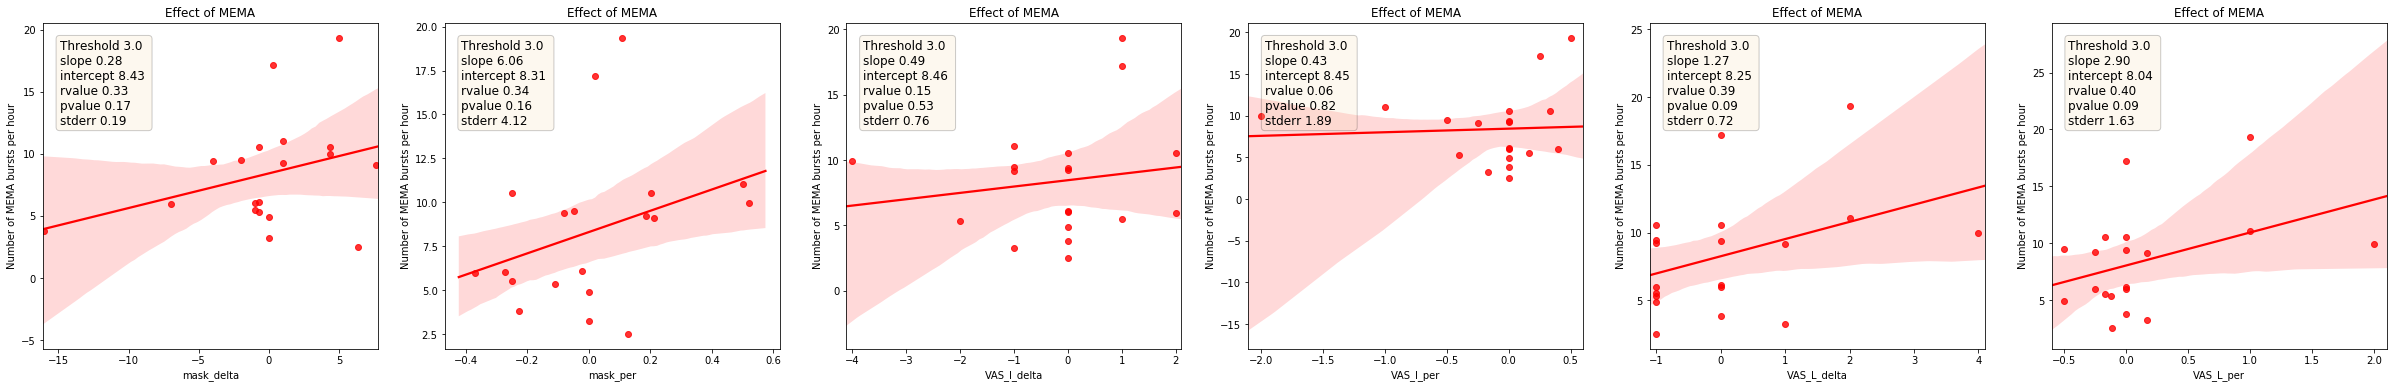

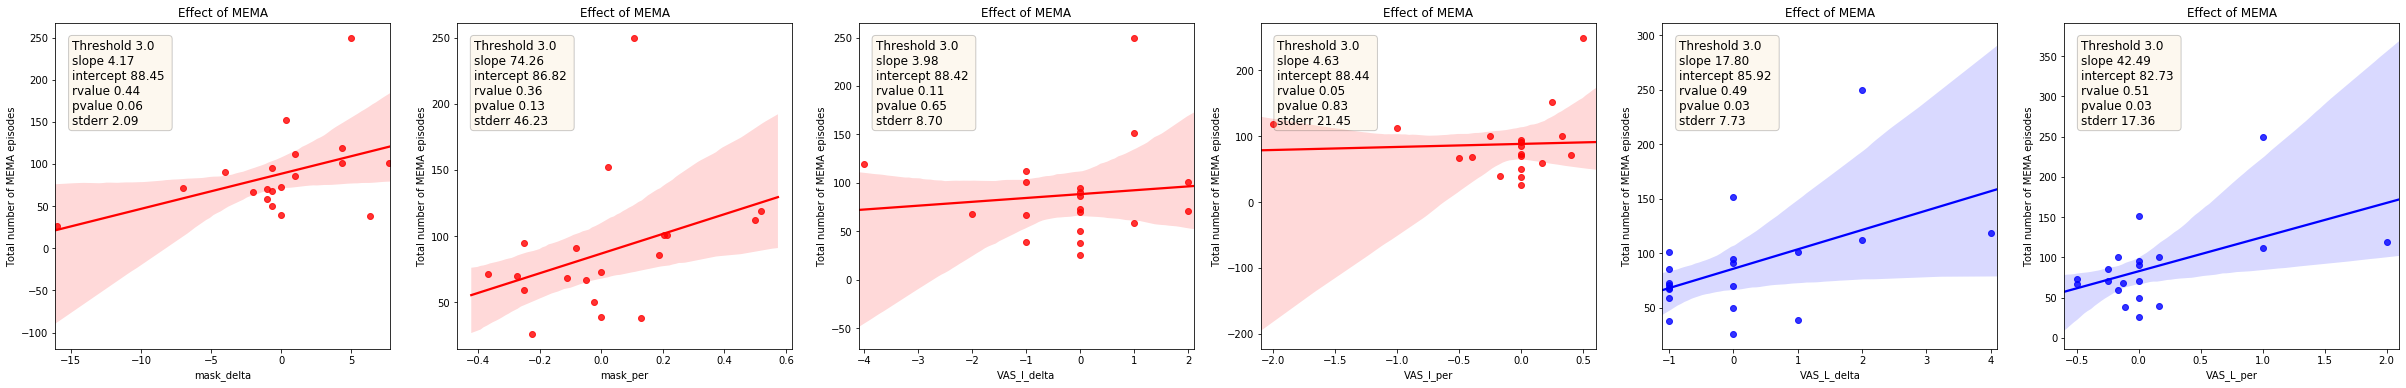

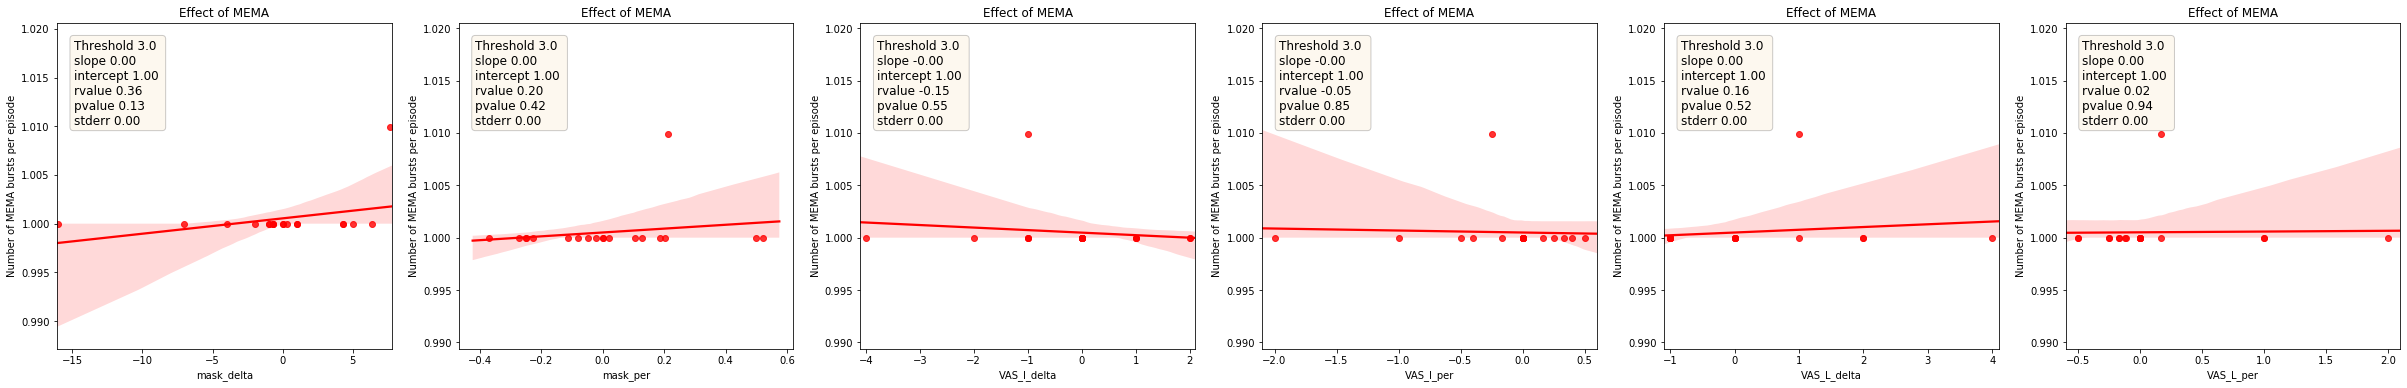

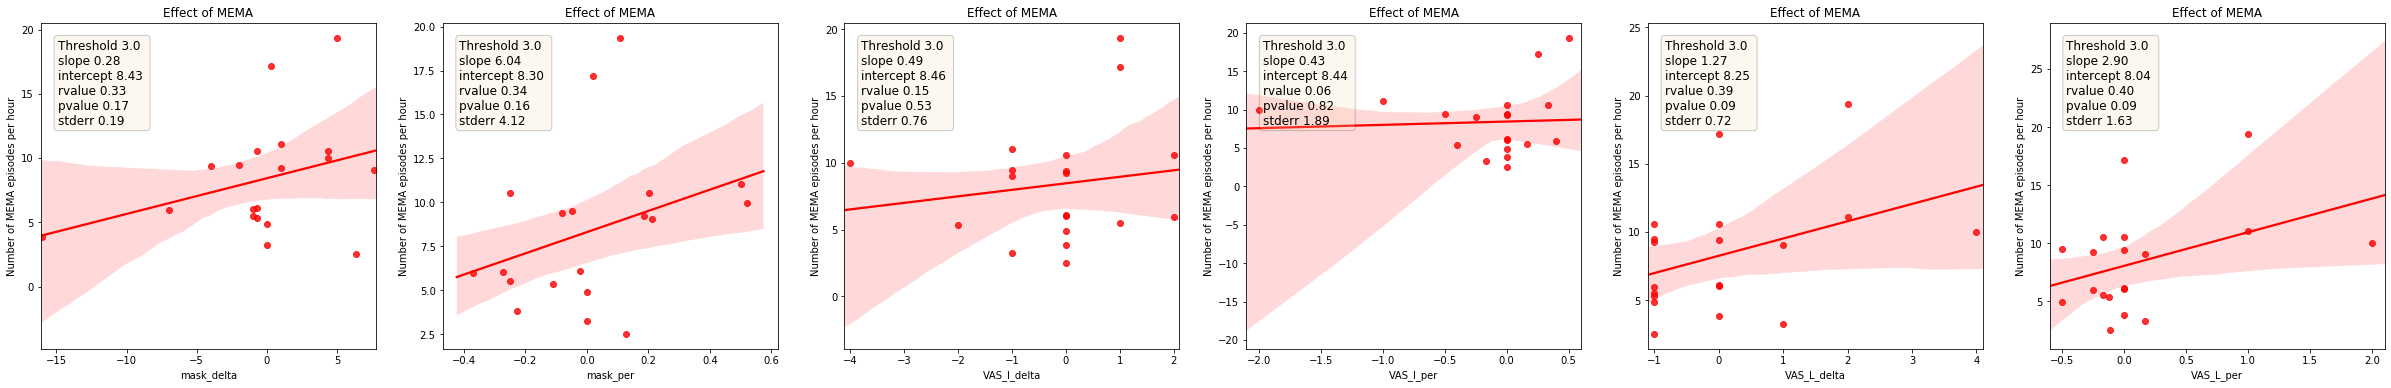

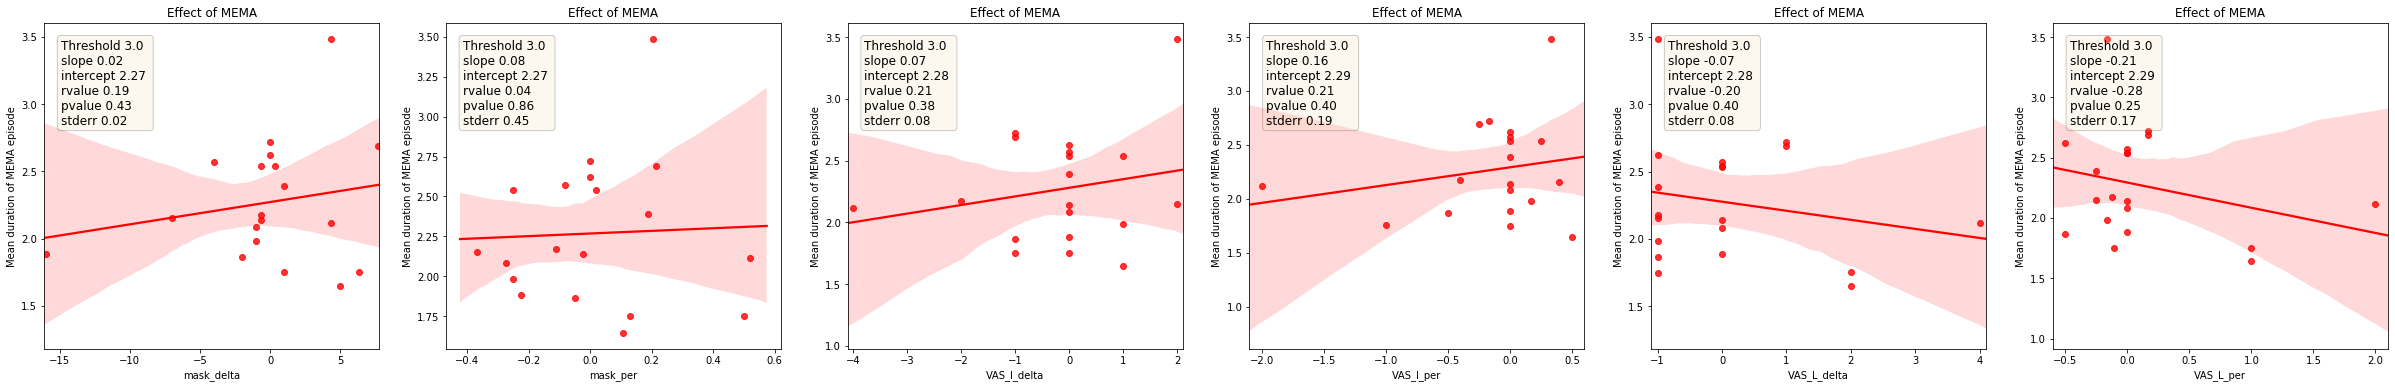

In [11]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            
            
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            if regression_result.pvalue < 0.01:
                    color = 'g'
            elif regression_result.pvalue < 0.05:
                    color = 'b'
            else:
                    color = 'r'
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax,  color=color)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [13]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
0,mask_delta,Clean MEMA duration,3,778.812036,38705.745900,0.484435,0.035561,341.110467
0,mask_delta,Total MEMA burst duration,3,9.522595,199.400831,0.481854,0.036700,4.199955
0,VAS_L_delta,Total number of MEMA burst,3,17.825545,85.965732,0.488390,0.033868,7.724660
0,VAS_L_per,Total number of MEMA burst,3,42.498016,82.778380,0.510469,0.025535,17.362847
0,VAS_L_delta,Total number of MEMA episodes,3,17.799065,85.915888,0.487813,0.034111,7.725168
0,VAS_L_per,Total number of MEMA episodes,3,42.490700,82.726620,0.510536,0.025513,17.356760


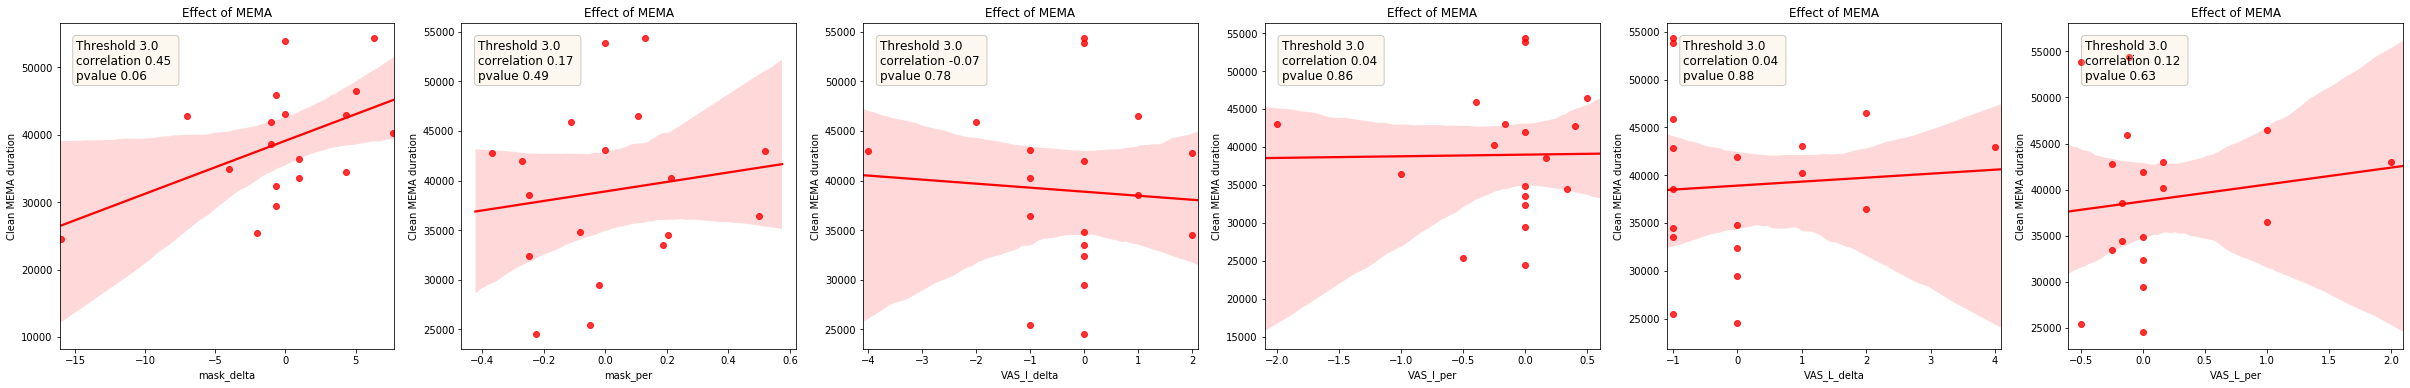

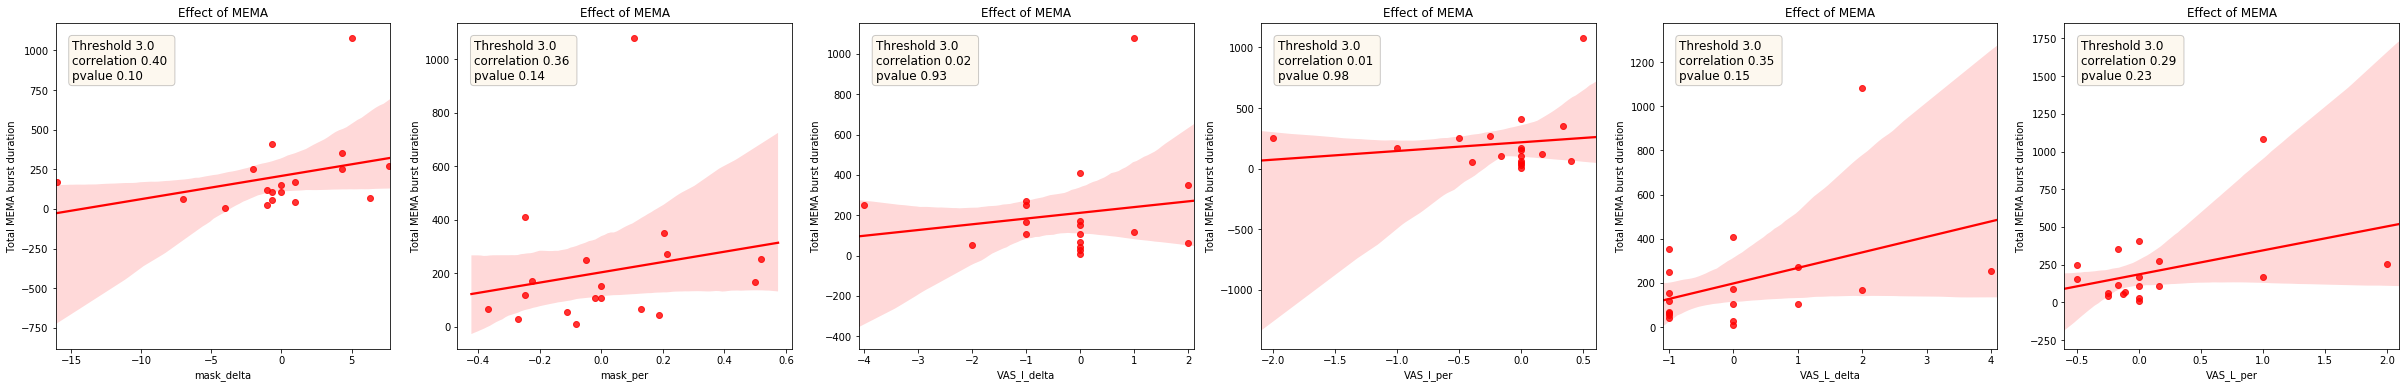

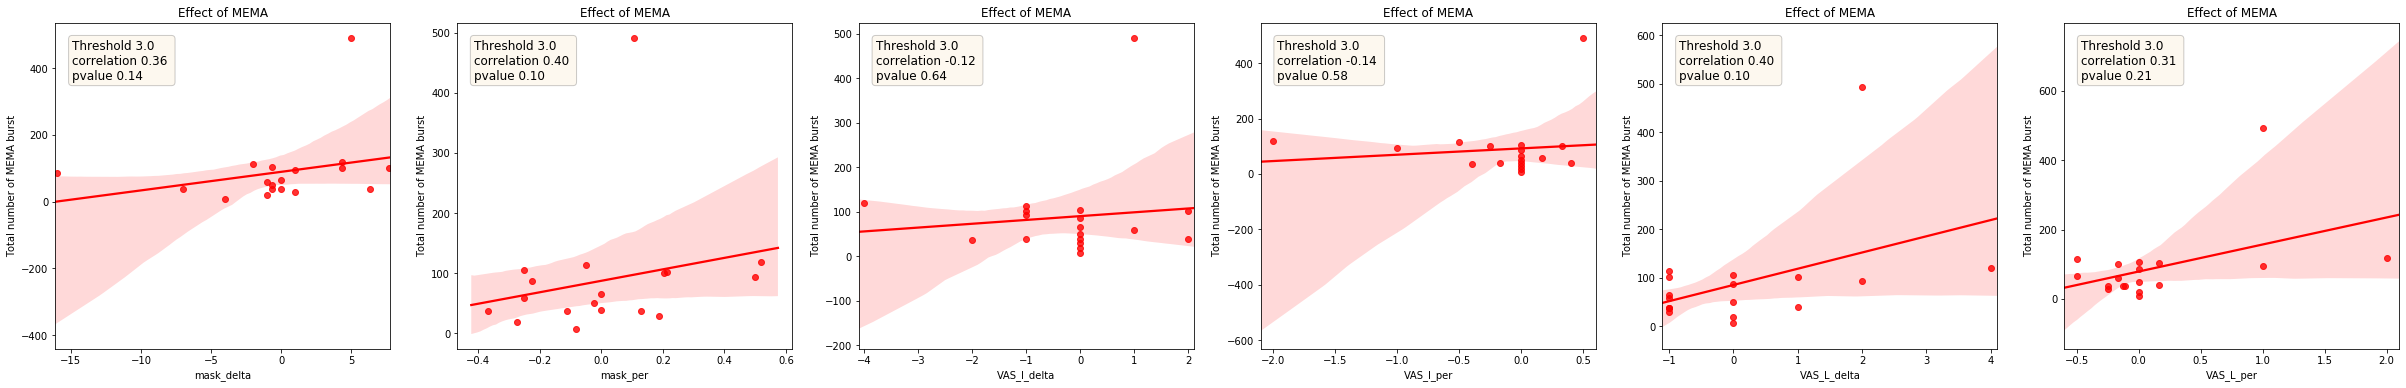

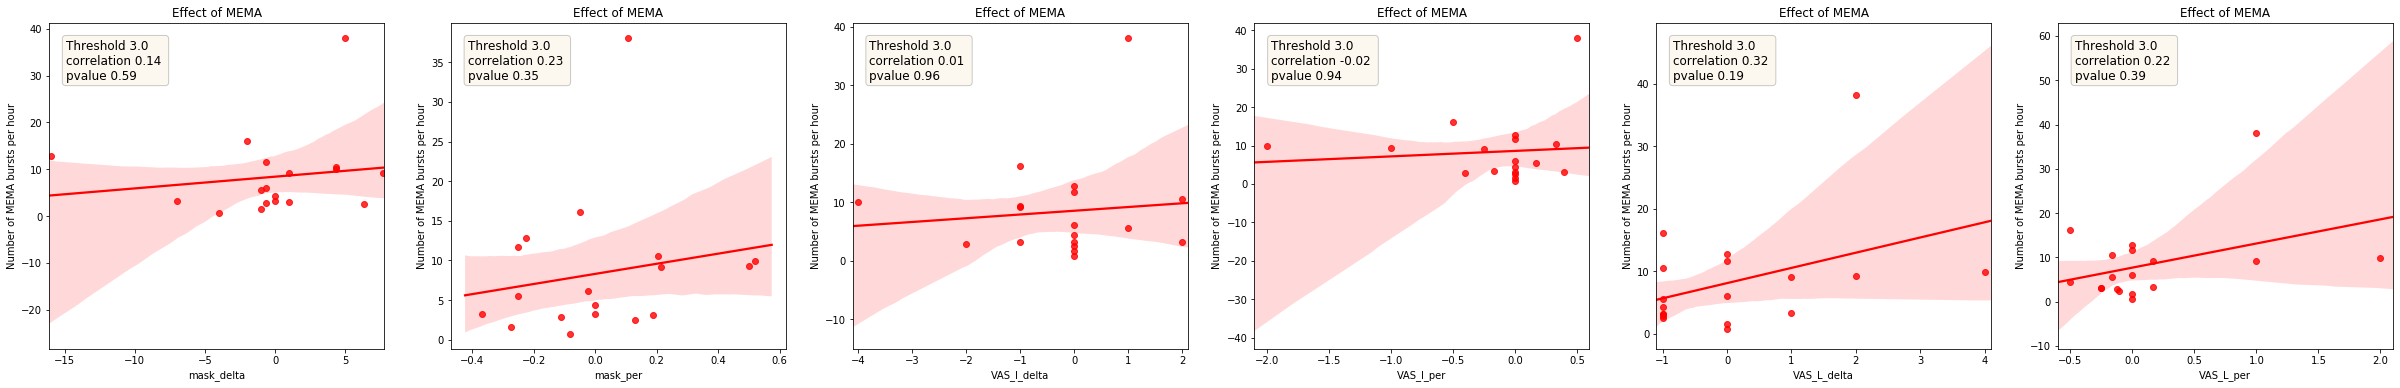

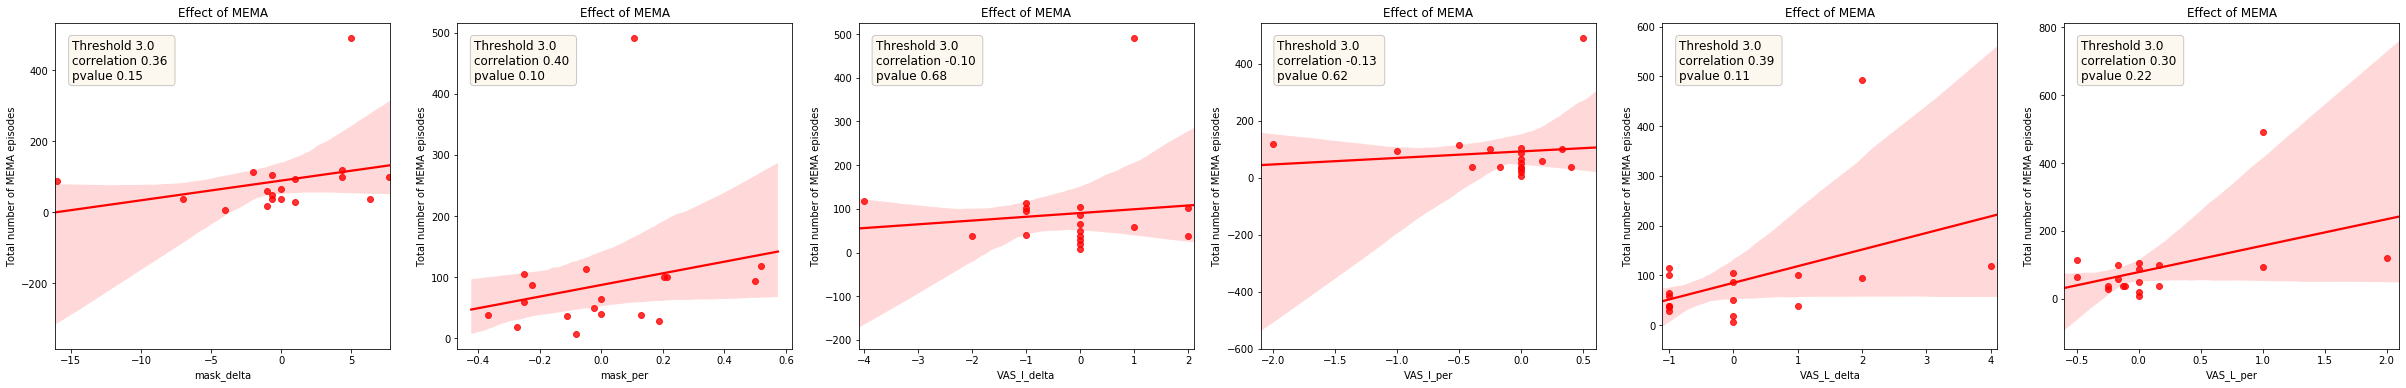

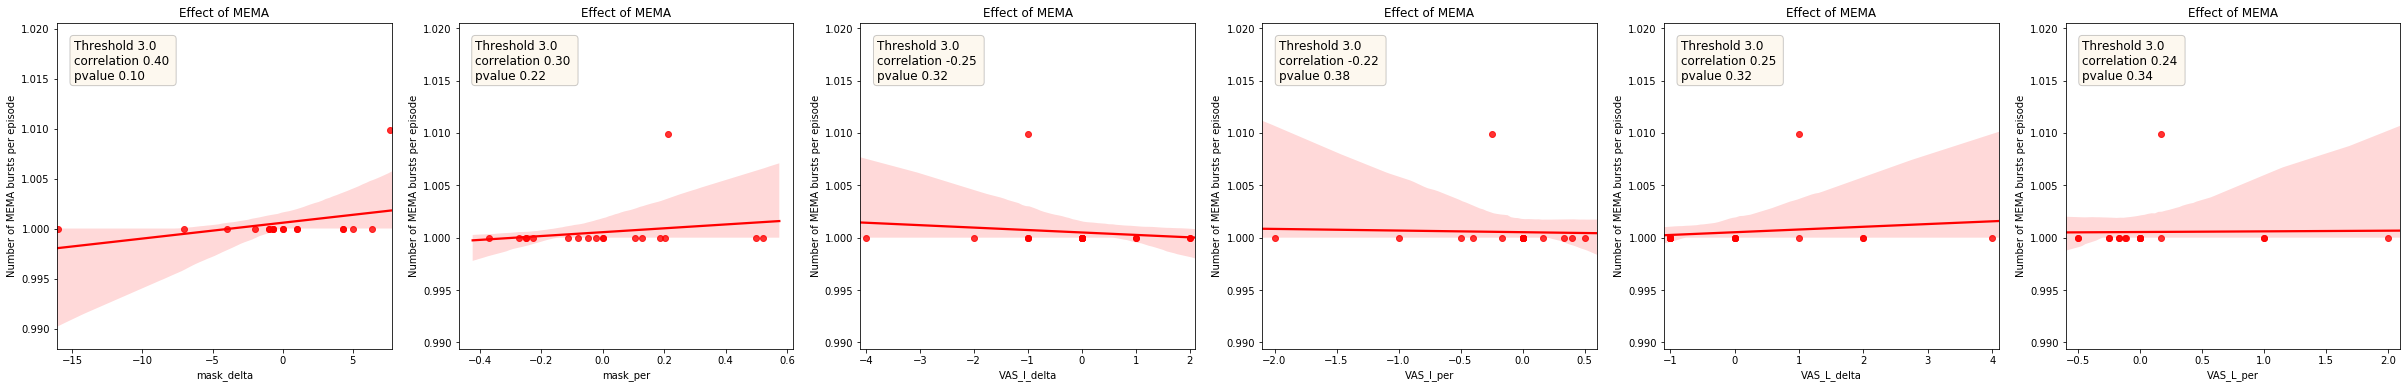

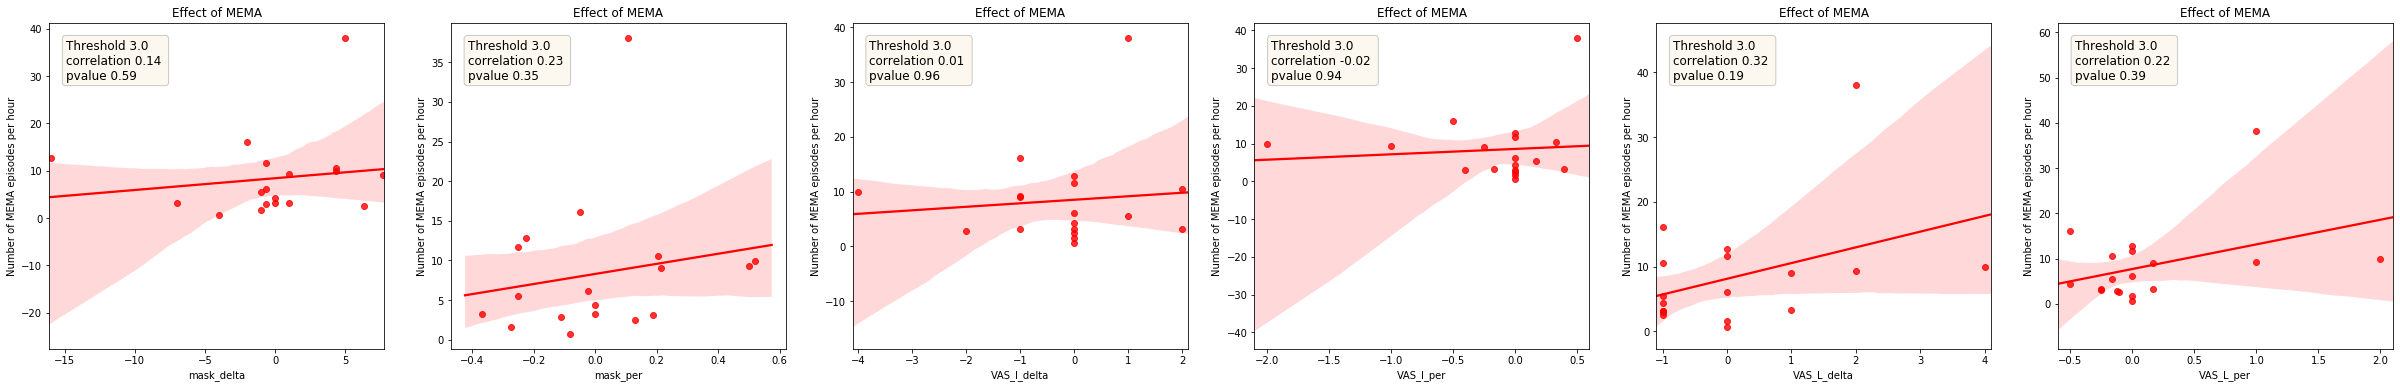

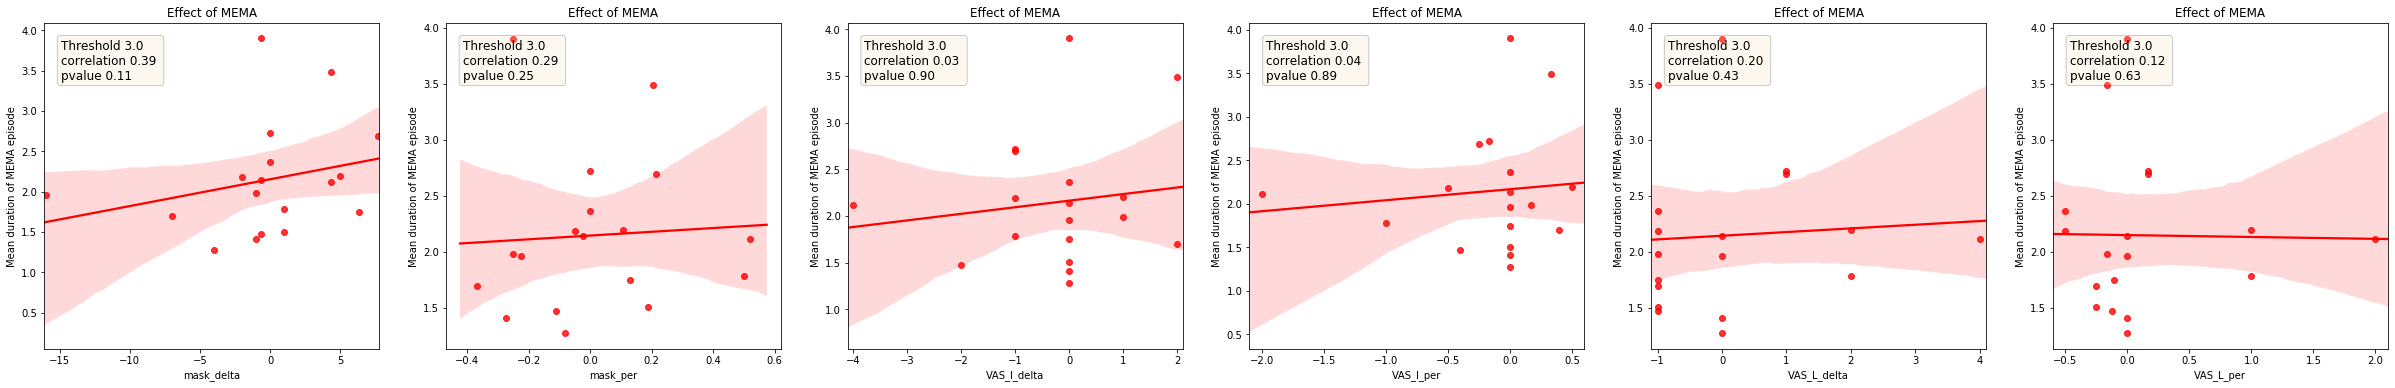

In [32]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            
            regression_result = scipy.stats.spearmanr(data_loc[x_axis].values,data_loc[y_axis].values)
            if regression_result.pvalue < 0.01:
                    color = 'g'
            elif regression_result.pvalue < 0.05:
                    color = 'b'
            else:
                    color = 'r'
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax,  color=color)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [33]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,correlation,pvalue


etiology (?) : 6, ['1DA15', '1GB18', '1HB20', '1SL21', '1UC22', '1ZN04']
etiology (group1) : 7, ['1HS25', '1PA31', '1RF29', '1GF14', '1DM32', '1NS30', '1AC26']
etiology (group3) : 6, ['3NS01', '3BS04', '3TR07', '3KB06', '3TS03', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_3 v.s. group1_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.519e-01 U_stat=2.900e+01
group1_3 v.s. group3_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.300e+01
?_3 v.s. group3_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.846e-01 U_stat=2.800e+01


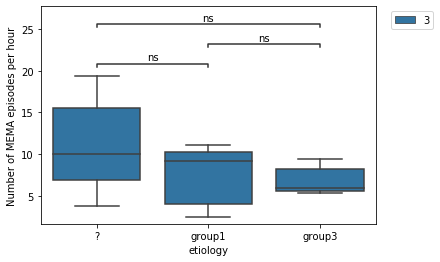

obstructed_ear (False) : 8, ['1DA15', '1HB20', '1HS25', '1RF29', '3TR07', '3KB06', '3TS03', '3HS08']
obstructed_ear (True) : 11, ['1GB18', '1SL21', '1UC22', '1ZN04', '1PA31', '3NS01', '1GF14', '1DM32', '3BS04', '1NS30', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.312e-01 U_stat=2.900e+01


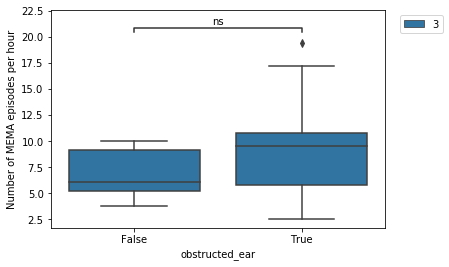

otalgy (False) : 15, ['1DA15', '1GB18', '1HB20', '1SL21', '1UC22', '1ZN04', '1HS25', '3NS01', '1RF29', '1GF14', '3BS04', '3TR07', '3KB06', '1NS30', '3TS03']
otalgy (True) : 4, ['1PA31', '1DM32', '1AC26', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.263e-01 U_stat=3.400e+01


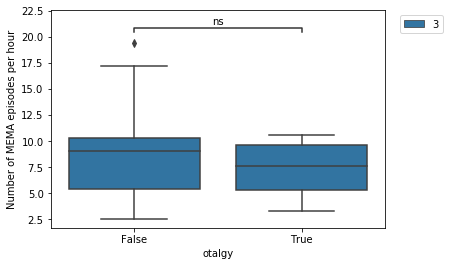

hyperacusis (True) : 9, ['1DA15', '1ZN04', '1PA31', '1RF29', '1GF14', '1DM32', '3KB06', '3TS03', '3HS08']
hyperacusis (False) : 10, ['1GB18', '1HB20', '1SL21', '1UC22', '1HS25', '3NS01', '3BS04', '3TR07', '1NS30', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.779e-01 U_stat=6.200e+01


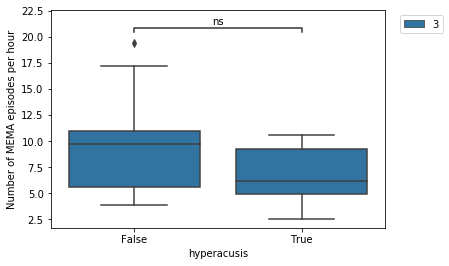

jaw_popping (True) : 11, ['1DA15', '1SL21', '1ZN04', '1HS25', '1PA31', '3NS01', '1GF14', '1DM32', '3BS04', '1NS30', '3HS08']
jaw_popping (False) : 8, ['1GB18', '1HB20', '1UC22', '1RF29', '3TR07', '3KB06', '1AC26', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.497e-01 U_stat=5.000e+01


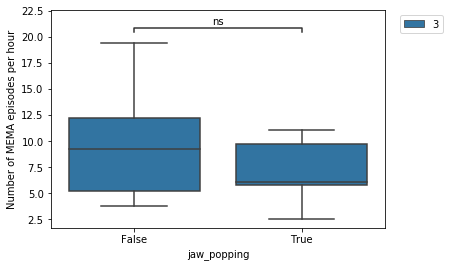

jaw_pain_and_fatigue (False) : 14, ['1DA15', '1GB18', '1HB20', '1SL21', '1UC22', '1ZN04', '3NS01', '1RF29', '1GF14', '3TR07', '3KB06', '1NS30', '3TS03', '3HS08']
jaw_pain_and_fatigue (True) : 5, ['1HS25', '1PA31', '1DM32', '3BS04', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.896e-01 U_stat=3.700e+01


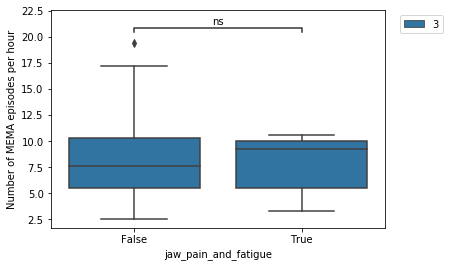

somatosensory_modulation (False) : 12, ['1DA15', '1GB18', '1HB20', '1SL21', '1ZN04', '3NS01', '1RF29', '1DM32', '3KB06', '1NS30', '3TS03', '3HS08']
somatosensory_modulation (True) : 7, ['1UC22', '1HS25', '1PA31', '1GF14', '3BS04', '3TR07', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.262e-01 U_stat=5.000e+01


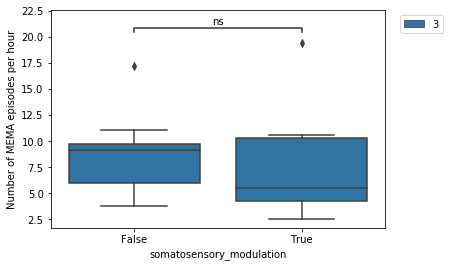

nap_modulation (False) : 14, ['1DA15', '1GB18', '1ZN04', '1PA31', '3NS01', '1GF14', '1DM32', '3BS04', '3TR07', '3KB06', '1NS30', '1AC26', '3TS03', '3HS08']
nap_modulation (True) : 5, ['1HB20', '1SL21', '1UC22', '1HS25', '1RF29']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.170e-01 U_stat=3.200e+01


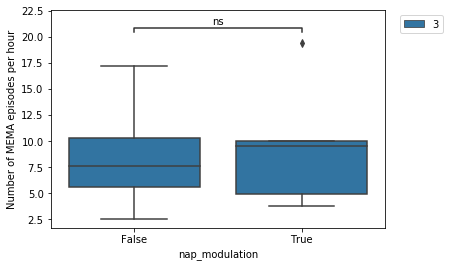

snoring (False) : 12, ['1DA15', '1GB18', '1ZN04', '1HS25', '3NS01', '1GF14', '1DM32', '3BS04', '3TR07', '1NS30', '3TS03', '3HS08']
snoring (True) : 7, ['1HB20', '1SL21', '1UC22', '1PA31', '1RF29', '3KB06', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.991e-01 U_stat=4.400e+01


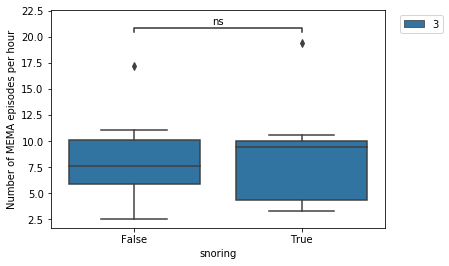

neck_pain (True) : 12, ['1DA15', '1HB20', '1HS25', '1PA31', '3NS01', '1RF29', '1GF14', '1DM32', '3BS04', '3KB06', '1AC26', '3TS03']
neck_pain (False) : 7, ['1GB18', '1SL21', '1UC22', '1ZN04', '3TR07', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.115e-02 U_stat=6.800e+01


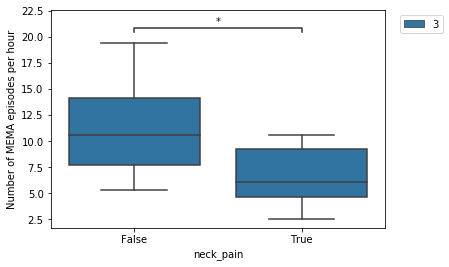

trauma_sonore (True) : 6, ['1DA15', '1GB18', '1UC22', '3TR07', '1NS30', '3HS08']
trauma_sonore (False) : 13, ['1HB20', '1SL21', '1ZN04', '1HS25', '1PA31', '3NS01', '1RF29', '1GF14', '1DM32', '3BS04', '3KB06', '1AC26', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.740e-01 U_stat=2.300e+01


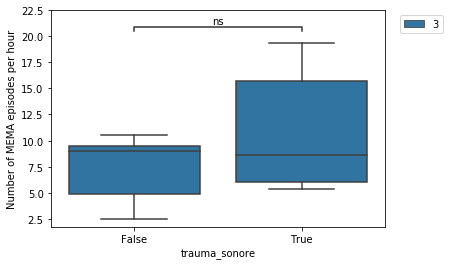

otite (False) : 10, ['1DA15', '1HS25', '3NS01', '1DM32', '3BS04', '3TR07', '3KB06', '1NS30', '3TS03', '3HS08']
otite (True) : 9, ['1GB18', '1HB20', '1SL21', '1UC22', '1ZN04', '1PA31', '1RF29', '1GF14', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.674e-01 U_stat=4.400e+01


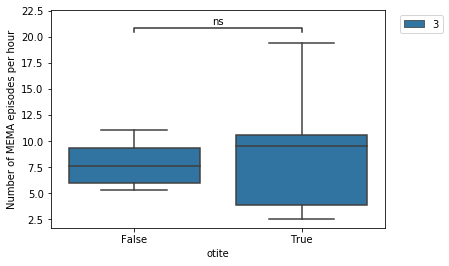

Ear clapping (False) : 8, ['1DA15', '1HB20', '1SL21', '1HS25', '1DM32', '3BS04', '3TR07', '3KB06']
Ear clapping (True) : 11, ['1GB18', '1UC22', '1ZN04', '1PA31', '3NS01', '1RF29', '1GF14', '1NS30', '1AC26', '3TS03', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.915e-01 U_stat=3.700e+01


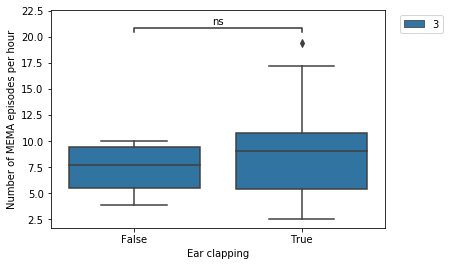

In [40]:
# e.1 GROUP BY ETIOLOGIES
plt.close("all")
from tinnsleep.visualization import etiology_report_with_plot

data = reports.query("category != 'control'")
variable = "Number of MEMA episodes per hour"
#variable = 'Total number of MEMA episodes'

hue = "THR_classif"
threshold = 3

etiologies = ['etiology', 'obstructed_ear', 'otalgy', 'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 
            'somatosensory_modulation', 'nap_modulation', 'snoring', "neck_pain", "trauma_sonore", "otite",
             "Ear clapping"]

for etiology in etiologies:
    etiology_report_with_plot(data, etiology, variable, hue=hue, hue_value_for_stats=threshold)
    plt.show()
    